# 워크넷 취업공고 크롤링
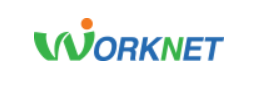

## Selenium 라이브러리 설치
## cx_Oracle 라이브러리 설치

In [1]:
# 링크 수집을 위한 라이브러리 설치
!pip install selenium
# 오라클 DB 연동을 위한 라이브러리 설치
!pip install cx_Oracle

You should consider upgrading via the 'c:\users\82109\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\82109\anaconda3\python.exe -m pip install --upgrade pip' command.


## 패키지 import
## csv 저장 경로 지정

In [1]:
from bs4 import BeautifulSoup 
import requests 
from urllib.request import urlopen
from selenium import webdriver as wd 
from selenium.webdriver.common.keys import Keys 
import time 
import re 
import os 
import pandas as pd
import numpy as np

# 자신이 파일을 저장할 경로를 지정
os.chdir(r'C:\Users\qkrqj\workspace\JupyterNotebook\csv')

os.getcwd()

'C:\\Users\\qkrqj\\workspace\\JupyterNotebook\\csv'

# DataBase

## 테이블 정보
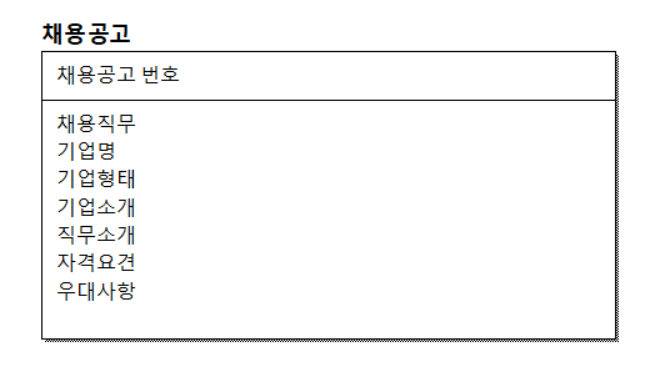
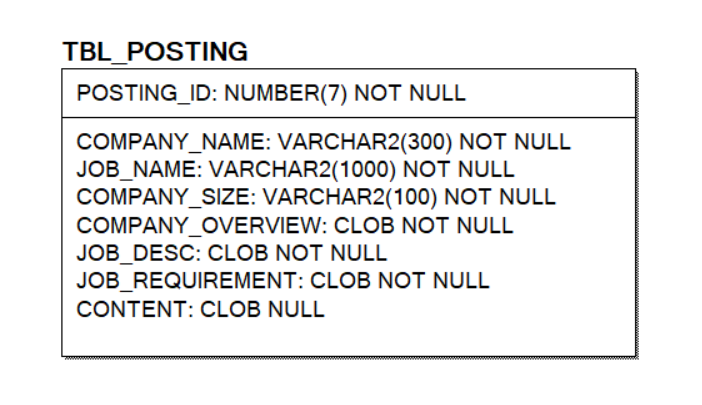

## cx_Oracle improt
## DB 연동 후 데이터 insert 하는 함수 정의

In [2]:
import cx_Oracle

# 한글 지원 방법
os.putenv('NLS_LANG', '.UTF8')

def insert(data):
    
    # 연결에 필요한 기본 정보 (유저, 비밀번호, 데이터베이스 서버 주소)
    database_server = 'localhost/xe'
    username = 'HMIS'
    password = '1234'

    # DB 연결
    connection = cx_Oracle.connect(username, password, database_server)

    # 커서 생성
    cursor = connection.cursor()

    print("CSV INSERT 시작")

    query = """             
        INSERT INTO TBL_POSTING (
            POSTING_ID
            , JOB_NAME
            , COMPANY_NAME
            , COMPANY_SIZE
            , COMPANY_OVERVIEW
            , JOB_DESC
            , JOB_REQUIREMENT
            , CONTENT
            , SALARY
            , LINK_ADDRESS
        ) VALUES (
            SEQ_POSTING.NEXTVAL
            , :1
            , :2
            , :3
            , :4
            , :5
            , :6
            , :7
            , :8
            , :9
        ) 
        """
    # 쿼리문 작성
    #for index, row in job_csv_df.iterrows() :
        
    cursor.executemany(query, data.values.tolist())
        
    cursor.close()
    connection.commit()
    connection.close()

    print("DB insert 완료")

## DB 에 저장할 csv 파일의 중복 데이터 제거 함수 정의

In [3]:
def data_filter(job_csv_df) :
  
    # 중복데이터 개수 확인
    job_csv_df.duplicated(["채용직무","기업명"]).value_counts()

    # 중복데이터 확인
    job_csv_df.duplicated(["채용직무","기업명"])

    # 중복데이터 제거
    job_csv_df = job_csv_df.drop_duplicates(["채용직무","기업명"],keep="last")

    return job_csv_df

# Crawling

## Selenium import
## webdriver 설정

In [5]:
# set options to be headless, ..
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome('chromedriver',options=options)

## 워크넷에서 등록한 채용공고의 링크만 수집하는 함수 정의

In [6]:
# link 수집
def getPageLinksWantRange(startPage, lastPage):
  links = [] 
  detailLinks = []

  for pageNo in range(startPage -1 , lastPage) :

    url = "https://www.work.go.kr/empInfo/empInfoSrch/list/dtlEmpSrchList.do?webIsOut=region&region=30000&pageIndex=" + str(pageNo + 1)

    html = urlopen(url) # 페이지 접속
    soup = BeautifulSoup(html, "html.parser", from_encoding='utf-8') # html 파싱을 위한 객체 생성 -> 접속한 페이지의 전체 화면 html 태그 정보
    div = soup.find('table', {'class':'board-list'} )

    # = div.find_all('a', {'title':'새창 열림'} )

    for number in range(1,11):
        
      try:
        
        
        tr_id = 'list'+ str(number)
        tr = div.find('tr', {'id':tr_id} )      
        i = tr.find('i', {'class' : 'iconset ico-certi-worknet'})
        link = tr.find_all('a', {'title':'새창 열림'} )
        st = link[1].get('href')
        
        print(st)
        
        if st.find('/empInfo') != -1:
          links.append("https://www.work.go.kr"+st)

        else:
          print('not appeand')  
        
      except:
        print('except')


  return links

## 채용공고 상세보기 페이지에서 원하는 정보를 가져오는 함수 정의

In [51]:
def getDataFromWorknet(links):
    job_name_infos = []
    company_name_infos = []
    company_size_infos = []
    company_overview_infos= []
    job_desc_infos= []
    job_requirement_infos= []
    content_infos = []
    salary_infos = []
    link_address_infos = []
    
    url2 = "https://www.work.go.kr" 

    driver = webdriver.Chrome('chromedriver',options=options)
    driver.get(url2) 
    time.sleep(3.0) # 30 

    driver.find_element_by_css_selector('body').send_keys(Keys.CONTROL + "t")

    for link in links:
        try: 
            print(link + ' 수집 중......')   
            print("======================================================")
            driver.switch_to.window(driver.window_handles[-1]) 
            time.sleep(0.1) 
            driver.get(link) 
            time.sleep(0.1) 
            driver.switch_to.window(driver.window_handles[0]) 
            time.sleep(0.3)

            html_source = driver.page_source 

            html_soup = BeautifulSoup(html_source, 'lxml') 

            # 1) 채용 직무 job_name_infos
            job_name = html_soup.find('p', {'class':'tit'} ).text
            print(job_name)

            job_name_infos.append(job_name)

            # 2) 기업명 company_name_infos
            company_div = html_soup.select('div.info > ul > li > div')
            company_name = company_div[0].text
            company_name_infos.append(company_name.strip())

            # 3) 기업형태 company_size_infos
            company_size = company_div[2].text
            company_size_infos.append(company_size.strip())

            # 4) 회사소개 company_overview_infos
            # 4-1) 업종
            temp_type = company_div[1].text.strip()

            # 4-2) 연매출액
            temp_sales = company_div[4].text.strip()

            # 4-3) 근로자수
            temp_size = company_div[6].text.strip()

            company_overview = '업종: ' + temp_type + ' 연매출액: ' + temp_sales + ' 근로자수: ' + temp_size

            print(company_name)
            print(company_size)
            print(company_overview)

            company_overview_infos.append(company_overview)

            # 5) 직무소개 job_desc_infos
            job_div = html_soup.select('div.careers-table > table > tbody > tr > td')

            job_desc = job_div[0].text.strip()
            job_desc = re.sub("^\s+|\s+$", "", job_desc, flags=re.UNICODE) # 앞 뒤 공백 제거
            job_desc = re.sub('&nbsp;| |\t|\r|\n', '', job_desc) # html 공백 태그 제거

            job_desc_infos.append(job_desc.strip())


            # 6) 자격요건 job_requirement_infos
            #job_requirement_table = html_soup.select('div.careers-table v1 center mt20 > table > tr > td')
            job_requirement_table = html_soup.find('div', {'class':'careers-table v1 center mt20'} )
            job_requirement_td = job_requirement_table.find_all('td')

            # 6-1) 경력 조건
            experience_condition = job_requirement_td[0].text.strip() # 스트링에서 제공하는 공백(스페이스) 제거
            experience_condition = re.sub("^\s+|\s+$", "", experience_condition, flags=re.UNICODE) # 앞 뒤 공백 제거
            experience_condition = re.sub('&nbsp;| |\t|\r|\n', '', experience_condition) # html 공백 태그 제거


            # 6-2) 학력
            academic_background = job_requirement_td[1].text.strip()
            academic_background =re.sub("^\s+|\s+$", "", academic_background, flags=re.UNICODE)
            academic_background = re.sub('&nbsp;| |\t|\r|\n', '', academic_background)

            # 6-3) 고용 형태
            employment_type = job_requirement_td[2].text.strip()
            employment_type = re.sub("^\s+|\s+$", "", employment_type, flags=re.UNICODE)
            employment_type = re.sub('&nbsp;| |\t|\r|\n', '', employment_type)

            job_requirement_overview = '경력조건: ' + experience_condition + ' 학력: ' + academic_background + ' 고용형태: ' + employment_type
            job_requirement_infos.append(job_requirement_overview)



            # 7) 우대사항 content_infos
            content_div_1 = html_soup.find_all('div',{'class':'careers-table center'})
            content_div1 = content_div_1[2].select('table > tbody > tr > td')

            content_div_2 = html_soup.find('div',{'class':'careers-table cnts v1 mt20'})
            content_div2 = content_div_2.find_all('td')

            # 7-1) 전공
            temp_major = content_div1[0].text.strip()
            temp_major = re.sub("^\s+|\s+$", "", temp_major, flags=re.UNICODE) # 앞 뒤 공백 제거
            temp_major = re.sub('&nbsp;| |\t|\r|\n', '', temp_major) # html 공백 태그 제거

            # 7-2) 자격면허
            temp_license = content_div1[1].text.strip()
            temp_license = re.sub("^\s+|\s+$", "", temp_license, flags=re.UNICODE) # 앞 뒤 공백 제거
            temp_license = re.sub('&nbsp;| |\t|\r|\n', '', temp_license) # html 공백 태그 제거

            # 7-3) 외국어능력
            temp_foreign = content_div1[2].text.strip()
            temp_foreign = re.sub("^\s+|\s+$", "", temp_foreign, flags=re.UNICODE) # 앞 뒤 공백 제거
            temp_foreign = re.sub('&nbsp;| |\t|\r|\n', '', temp_foreign) # html 공백 태그 제거

            # 7-4) 병역대체복무자채용
            temp_military = content_div1[3].text.strip()
            temp_military = re.sub("^\s+|\s+$", "", temp_military, flags=re.UNICODE) # 앞 뒤 공백 제거
            temp_military = re.sub('&nbsp;| |\t|\r|\n', '', temp_military) # html 공백 태그 제거

            # 7-5) 고용허가제
            temp_Employment = content_div1[4].text.strip()
            temp_Employment = re.sub("^\s+|\s+$", "", temp_Employment, flags=re.UNICODE) # 앞 뒤 공백 제거
            temp_Employment = re.sub('&nbsp;| |\t|\r|\n', '', temp_Employment) # html 공백 태그 제거

            # 7-6) 우대조건
            temp_preferential = content_div2[0].text.strip()
            temp_preferential = re.sub("^\s+|\s+$", "", temp_preferential, flags=re.UNICODE) # 앞 뒤 공백 제거
            temp_preferential = re.sub('&nbsp;| |\t|\r|\n', '', temp_preferential) # html 공백 태그 제거

            # 7-7) 컴퓨터활용능력
            temp_computer = content_div2[1].text.strip()
            temp_computer = re.sub("^\s+|\s+$", "", temp_computer, flags=re.UNICODE) # 앞 뒤 공백 제거
            temp_computer = re.sub('&nbsp;| |\t|\r|\n', '', temp_computer) # html 공백 태그 제거

            # 7-8) 기타우대사항
            temp_preferential_etc = content_div2[2].text.strip()
            temp_preferential_etc = re.sub("^\s+|\s+$", "", temp_preferential_etc, flags=re.UNICODE) # 앞 뒤 공백 제거
            temp_preferential_etc = re.sub('&nbsp;| |\t|\r|\n', '', temp_preferential_etc) # html 공백 태그 제거

            # 7-9) 작업환경
            temp_Environment = content_div2[3].text.strip()
            temp_Environment = re.sub("^\s+|\s+$", "", temp_Environment, flags=re.UNICODE) # 앞 뒤 공백 제거
            temp_Environment = re.sub('&nbsp;| |\t|\r|\n', '', temp_Environment) # html 공백 태그 제거
            
            
            content = '전공: ' + temp_major + ' 자격면허: ' + temp_license + ' 외국어능력: ' + temp_foreign + ' 병역대체복무자채용: ' + temp_military + ' 고용허가제: ' + temp_Employment + ' 우대조건: ' + temp_preferential + ' 컴퓨터활용능력: ' + temp_computer + ' 기타우대사항: ' + temp_preferential_etc + ' 작업환경: ' + temp_Environment
            content_infos.append(content)

            # 8) 임금
            salary_div = html_soup.select('div.cont > ul > li > span')
            salary = salary_div[3].text.strip()
            salary = re.sub("^\s+|\s+$", "", salary, flags=re.UNICODE) # 앞 뒤 공백 제거
            salary = re.sub('&nbsp;| |\t|\r|\n', '', salary) # html 공백 태그 제거
            salary_infos.append(salary)
            
            # 9) 링크
            link_address_infos.append(link)
            
            # 크롤링 정보 dictionary형태로 저장
            job_dic = {"채용직무":job_name_infos, "기업명":company_name_infos,"기업규모":company_size_infos, "기업소개":company_overview_infos,"직무소개":job_desc_infos,"자격요건": job_requirement_infos, "우대사항":content_infos, "임금":salary_infos, "링크":link_address_infos} 

            job_df = pd.DataFrame(job_dic)

        except:
            print(link)
            print("pass")
            
    return job_df 

## 최근등록일순으로 정렬하여 2021년 10월 12일까지 등록된 채용공고 수집
## 1페이지당 10건씩 ~ 260 페이지 2,599건 중 1,836건 수집
## 조건 : 대전, 상용직
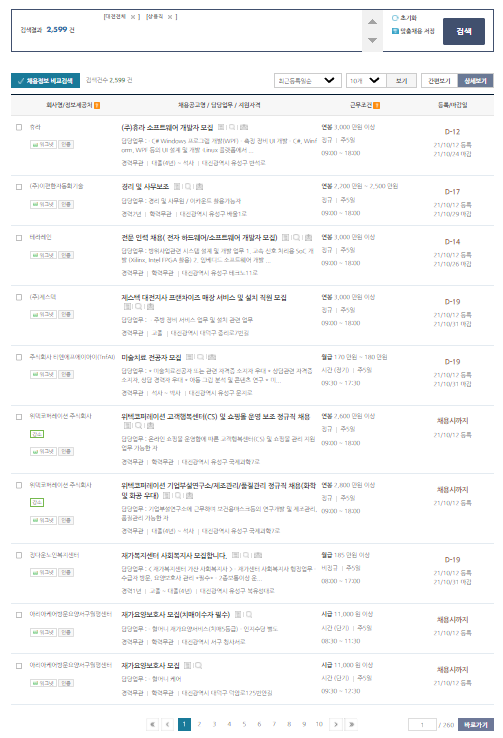
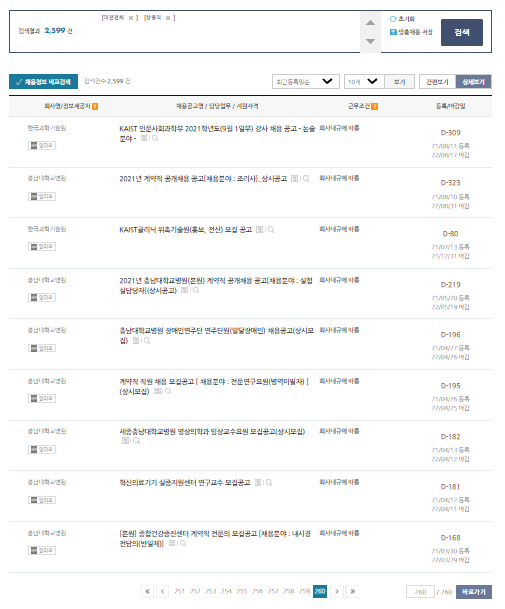

In [52]:
link = getPageLinksWantRange(1,281)

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002111050001&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111050017&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111050016&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10892111050003&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111050014&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111050013&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111050012&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K161132111040059&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040062&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040061&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040060&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040059&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040058&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040057&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K120122111040012&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFE002111040003&rtnTarget=list2
except
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040011&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10892111040002&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040010&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040008&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040007&rtnTarget=list8
/empInfo/empInfoSrch/detail/empDet

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030080&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030079&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030078&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030077&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030076&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030075&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030074&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030021&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030018&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFD002111030001&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030016&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030015&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030014&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030013&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020071&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFD002111020003&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020069&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020068&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020067&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020066&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170082111020024&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020006&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KHA0122111020001&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020005&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020004&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020003&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020002&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902111020003&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFD002111010003&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010079&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010077&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010076&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010074&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010073&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010072&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010024&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010023&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010022&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010021&rtnTarget=list4
except
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=P&callPage=detail&wantedAuthNo=DdA3052111012031&rtnTarget=list6&pageIndex=70&rtnUrl=/empInfo/empInfoSrch/list/dtlEmpSrchList.do?len=0&pageSize=10&firstIndex=1&lastIndex=1&recordCountPerPage=10&region=30000&siteClcd=all&benefitSrchAndOr=O&areaRegion=11000&areaArc=1&codeDepth1Info=11000&codeDepth2Info=11000&srchJobNum=0&empTpGbcd=1&sortField=DATE&sortOrderBy=DESC&resultCnt=10&&onl

#retrivePriEmpDtlViewAjax41492265
not appeand
#retrivePriEmpDtlViewAjax41492203
not appeand
#retrivePriEmpDtlViewAjax41492197
not appeand
#retrivePriEmpDtlViewAjax41491629
not appeand
#retrivePriEmpDtlViewAjax39566640
not appeand
#retrivePriEmpDtlViewAjax39566023
not appeand
#retrivePriEmpDtlViewAjax39562655
not appeand
#retrivePriEmpDtlViewAjax41475991
not appeand
#retrivePriEmpDtlViewAjax39551925
not appeand
#retrivePriEmpDtlViewAjax39487177
not appeand
#retrivePriEmpDtlViewAjax2109290005121
not appeand
#retrivePriEmpDtlViewAjax41491996
not appeand
#retrivePriEmpDtlViewAjax41491963
not appeand
#retrivePriEmpDtlViewAjax41491829
not appeand
#retrivePriEmpDtlViewAjax2110310000361
not appeand
#retrivePriEmpDtlViewAjax2110310000205
not appeand
#retrivePriEmpDtlViewAjax2110310000152
not appeand
#retrivePriEmpDtlViewAjax39571872
not appeand
except
#retrivePriEmpDtlViewAjax39571717
not appeand
#retrivePriEmpDtlViewAjax2110300000324
not appeand
#retrivePriEmpDtlViewAjax2110300000256
not appea

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110290002&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110290001&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KEC0152110290001&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFD002110290001&rtnTarget=list4
#retrivePriEmpDtlViewAjax81673-76313
not appeand
#retrivePriEmpDtlViewAjax41487354
not appeand
except
#retrivePriEmpDtlViewAjax41486554
not appeand
#retrivePriEmpDtlViewAjax41485956
not appeand
#retrivePriEmpDtlViewAjax39566722
not appeand
#retrivePriEmpDtlViewAjax2110290002996
not appeand
#retrivePriEmpDtlViewAjax41485566
not appeand
#retrivePriEmpDtlViewAjax41485564
not appeand
except
except
#retrivePriEmpDtlViewAjax41485329
not appeand
#retriveP

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110280006&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110280005&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110280004&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902110280002&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110280003&rtnTarget=list5
except
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K171112110280008&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110280002&rtnTarget=list8
/empInfo/empInfoSrch/detail/empDet

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFD002110270001&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K120412110270017&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFF002110270002&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110270023&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K151132110270021&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110270022&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110270021&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110260072&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110260071&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110260070&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFD002110260001&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10892110260004&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110260068&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110260064&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

#retrivePriEmpDtlViewAjax41459521
not appeand
#retrivePriEmpDtlViewAjax41459403
not appeand
#retrivePriEmpDtlViewAjax41458915
not appeand
#retrivePriEmpDtlViewAjax39533632
not appeand
#retrivePriEmpDtlViewAjax39533209
not appeand
#retrivePriEmpDtlViewAjax39532954
not appeand
except
#retrivePriEmpDtlViewAjax41457883
not appeand
#retrivePriEmpDtlViewAjax39532107
not appeand
#retrivePriEmpDtlViewAjax41457378
not appeand
#retrivePriEmpDtlViewAjax39532018
not appeand
#retrivePriEmpDtlViewAjax41456707
not appeand
#retrivePriEmpDtlViewAjax41456614
not appeand
#retrivePriEmpDtlViewAjax41456327
not appeand
except
#retrivePriEmpDtlViewAjax39530585
not appeand
#retrivePriEmpDtlViewAjax39530189
not appeand
#retrivePriEmpDtlViewAjax39528187
not appeand
#retrivePriEmpDtlViewAjax2110260001205
not appeand
#retrivePriEmpDtlViewAjax39528005
not appeand
#retrivePriEmpDtlViewAjax39527508
not appeand
#retrivePriEmpDtlViewAjax39527031
not appeand
#retrivePriEmpDtlViewAjax39526982
not appeand
#retrivePriEmpD

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250017&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K120032110250024&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250013&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250012&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250011&rtnTarget=list5
except
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250010&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250009&rtnTarget=list8
/empInfo/empInfoSrch/detail/empDet

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110220008&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFE002110220002&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110220007&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110220005&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFE002110220001&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110220004&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110220003&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=Dd03902110210001&rtnTarget=list1
#retrivePriEmpDtlViewAjax39493535
not appeand
#retrivePriEmpDtlViewAjax39492724
not appeand
#retrivePriEmpDtlViewAjax39492364
not appeand
#retrivePriEmpDtlViewAjax39491693
not appeand
#retrivePriEmpDtlViewAjax39490151
not appeand
#retrivePriEmpDtlViewAjax2110210001552
not appeand
#retrivePriEmpDtlViewAjax2110210001540
not appeand
#retrivePriEmpDtlViewAjax39488528
not appeand
#retrivePriEmpDtlViewAjax39486796
not appeand
#retrivePriEmpDtlViewAjax39486150
not appeand
#retrivePriEmpDtlViewAjax2110210000415
not appeand
#retrivePriEmpDtlViewAjax2110210000329
not appeand
#retrivePriEmpDtlViewAjax39485282
not appeand
#retrivePriEmpDtlViewAjax39485063
not appeand
#retrivePriEmpDtlViewAjax39484747
not appeand
#retrivePriEmpDtlViewAjax2110210000138
not appeand
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthN

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902110200001&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110200008&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110200007&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110200006&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110200005&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110200004&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110200003&rtnTarget=list7
#retrivePriEmpDtlViewAjax39481003
not app

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110190003&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110190002&rtnTarget=list2
#retrivePriEmpDtlViewAjax442180230000
not appeand
#retrivePriEmpDtlViewAjax39469788
not appeand
except
#retrivePriEmpDtlViewAjax39468195
not appeand
#retrivePriEmpDtlViewAjax39466559
not appeand
#retrivePriEmpDtlViewAjax2110190002678
not appeand
#retrivePriEmpDtlViewAjax39465694
not appeand
#retrivePriEmpDtlViewAjax39465506
not appeand
#retrivePriEmpDtlViewAjax2110190001505
not appeand
#retrivePriEmpDtlViewAjax2110190001337
not appeand
#retrivePriEmpDtlViewAjax2110190001317
not appeand
#retrivePriEmpDtlViewAjax2110190001272
not appeand
#retrivePriEmpDtlViewAjax39463231
not appeand
#retrivePriEmpDtlViewAjax39462388
not appeand
#retrivePriEmpDtlViewAjax39462386
not appeand
#retrivePriEmpDtlViewAjax39462299
not appeand


#retrivePriEmpDtlViewAjax39450765
not appeand
#retrivePriEmpDtlViewAjax2110180001633
not appeand
#retrivePriEmpDtlViewAjax39449338
not appeand
#retrivePriEmpDtlViewAjax39448761
not appeand
#retrivePriEmpDtlViewAjax39448224
not appeand
#retrivePriEmpDtlViewAjax39447856
not appeand
#retrivePriEmpDtlViewAjax39447288
not appeand
#retrivePriEmpDtlViewAjax39445200
not appeand
#retrivePriEmpDtlViewAjax39443932
not appeand
#retrivePriEmpDtlViewAjax39443652
not appeand
#retrivePriEmpDtlViewAjax19306059
not appeand
#retrivePriEmpDtlViewAjax19306058
not appeand
#retrivePriEmpDtlViewAjax39441631
not appeand
#retrivePriEmpDtlViewAjax39441597
not appeand
#retrivePriEmpDtlViewAjax2110160000174
not appeand
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002110150001&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K130052110150017&rtnTarget=list7
/empInfo/empInfoSrch/detai

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110140066&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002110140009&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110140063&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110140062&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10892110140002&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110140061&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K120142110140019&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110130056&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110130055&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110130054&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110130052&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110130050&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110130049&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110130048&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120082&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120081&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120079&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120073&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120070&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120066&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=Dd03902110120038&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110080067&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110080062&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110080057&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110080056&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170042110080014&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002110080001&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110080048&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110070034&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002110070001&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110070030&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110070027&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110070026&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110070024&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110070022&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110060021&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002110060001&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110060014&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110060012&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110060010&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110060007&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110060002&rtnTarget=list7
#retrivePriEmpDtlViewAjax2110060005252
no

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050030&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050029&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050026&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050023&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050022&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K120142110050023&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050017&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109300048&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109300047&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109300043&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109300040&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109300038&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109300032&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFB002109300001&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002109280002&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109280057&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109280050&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109280049&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109280048&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109280045&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109280042&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109240075&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109240069&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002109240002&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109240067&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109240060&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109240058&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109240056&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K120032109170022&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109170024&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFE002109170001&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109170003&rtnTarget=list4
#retrivePriEmpDtlViewAjax39215641
not appeand
#retrivePriEmpDtlViewAjax39214382
not appeand
#retrivePriEmpDtlViewAjax2109170000280
not appeand
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109160048&rtnTarget=list8
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109160040&rtnTarget=list9
/empInfo/empInfoSrch/detail/empDeta

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109130028&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFE002109130002&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109130025&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109130023&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109130022&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109130021&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109130020&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109080056&rtnTarget=list1
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109080049&rtnTarget=list2
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109080046&rtnTarget=list3
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109080039&rtnTarget=list4
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109080038&rtnTarget=list5
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109080037&rtnTarget=list6
/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109080035&rtnTarget=list7
/empInfo/empInfoSrch/detail/empDetailAuth

## 수집된 링크의 개수 확인

In [53]:
len(link)

1852

## 채용공고 상세보기 페이지에서 원하는 정보를 가져오는 함수 실행

In [54]:
job_df = getDataFromWorknet(link)

https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002111050001&rtnTarget=list1 수집 중......
국민카드 대전센터 정규직 상담사 모집

                  (주)케이에스한국고용정보
                

                  
                    
                    
                      중견기업
                    
                  
                
업종: 콜센터 및 텔레마케팅 서비스업 연매출액: 150,000 백만원 근로자수: 4432 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111050017&rtnTarget=list2 수집 중......
문창시장매니저(기획사무원)

                  문창전통시장상인회
                

                  
                    -
                    
                  
                
업종: 기타 사무지원 서비스업 연매출액: - 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111050016&rtnTarget=list3 수집 중......
주식회사 스마트상사 입니다. 포토샵,일러스트 기

요양원 사무원 구인

                  이엘요양원
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: 350 백만원 근로자수: 46 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF11482111050001&rtnTarget=list9 수집 중......
웹디자이너 모집

                  (주)위너핏
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 상품 종합 도매업 연매출액: - 근로자수: 10 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902111050001&rtnTarget=list10 수집 중......
주간보호센터 사무

                  둔산주간보호센터
                

                  
                    -
                    
                  
                
업종: 그 외 기타 비거주 복지 서비스업 연매출액: - 근로자수: 24 명
https://www.work.go.kr/empInfo/empIn

사회복지사12(장애인) 구인

                  (사)한국신장장애인협회
                

                  
                    
                    
                      기타
                    
                  
                
업종: 그 외 기타 협회 및 단체 연매출액: - 근로자수: 95 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040069&rtnTarget=list2 수집 중......
주유 및 세차원 구함

                  타임셀프주유소
                

                  
                    -
                    
                  
                
업종: 운송장비용 주유소 운영업 연매출액: - 근로자수: 3 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040068&rtnTarget=list3 수집 중......
세무법인한결 둔산2지점 경력직 모집

                  세무법인한결
                

                  
                    -
                    
                  
                
업종: 세무사업 연매출액: - 근로자수: 6 명
https://www.work.go.kr/empInfo/em

현대모비스 배송 및 창고정리 직원구합니다.

                  (주)도마현대
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 자동차용 전용 신품 부품 판매업 연매출액: - 근로자수: 14 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040054&rtnTarget=list10 수집 중......
성실한 직원 구합니다 (주차차단기 설치 직원)

                  베스트파킹
                

                  
                    -
                    
                  
                
업종: 기타 비주거용 건물 건설업 연매출액: 250 백만원 근로자수: 2 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040053&rtnTarget=list1 수집 중......
관급공사 건축 시공 및 공무 기술자 구인

                  디엘종합건설(주)
                

                  
                    
                    
                      중소기업
                    
               

간호사구함

                  벤조인요양병원
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 보건업 연매출액: - 근로자수: 28 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFD002111040006&rtnTarget=list8 수집 중......
(대전 서구 온라인 취업박람회 참여업체)안내 고객상담(콜 상담)

                  주식회사 케스코
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 건축기술, 엔지니어링 및 기타 과학기술 서비스업 연매출액: 6,700 백만원 근로자수: 26 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFD002111040005&rtnTarget=list9 수집 중......
시설 과장 모집/한독종합상사

                  한독종합상사
                

                  
                    -
                    
                  
           

요양병원 원무과장 채용 (원무행정직)

                  의료법인한일의료재단패밀리요양병원
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 일반 병원 연매출액: - 근로자수: 60 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFD002111040002&rtnTarget=list6 수집 중......
(대전 서구 온라인 취업박람회 참여업체)유튜브 기획/편집

                  주식회사 케스코
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 건축기술, 엔지니어링 및 기타 과학기술 서비스업 연매출액: 6,700 백만원 근로자수: 26 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040031&rtnTarget=list7 수집 중......
물리치료사 구인

                  효심노인요양원
                

                  
                    -
                    
             

(광역새일센터 채용대행)간호조무사 채용

                  부사효주간보호센터
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: - 근로자수: 9 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040016&rtnTarget=list6 수집 중......
정량주입장비 설계 및 제작

                  캄리 주식회사
                

                  
                    -
                    
                  
                
업종: 그 외 기타 특수목적용 기계 제조업 연매출액: - 근로자수: 3 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040015&rtnTarget=list7 수집 중......
거래처 순회 배송사원 모집합니다.

                  주식회사월드그린
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 생활용품 도매업 연매출액: - 근로자수: 6 명
https://www.wor

배달,수거기사 모집(화물차운행)

                  정부물품재활용센타
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 중고 상품 소매업 연매출액: - 근로자수: 6 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K120312111040009&rtnTarget=list6 수집 중......
위생용품/소독방역 서비스 영업직 사원 신입 정규직 모집(대전지점)

                  (주)유칼릭스
                

                  
                    -
                    
                  
                
업종: 그 외 기타 분류 안된 화학제품 제조업 연매출액: 11,113 백만원 근로자수: 141 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111040002&rtnTarget=list7 수집 중......
차량목욕 요양보호사 선생님 구인/재가 요양보호사

                  대전목욕차노인복지센터
                

                  
                    -
                    
                  
                
업종: 사회

건설회사 경리 사무원

                  대륙건설산업
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 아파트 건설업 연매출액: 2,000 백만원 근로자수: 20 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030082&rtnTarget=list8 수집 중......
성모병원 장례식장 조리사 모집

                  (재)대전교구천주교회유지재단
                

                  
                    -
                    
                  
                
업종: 장례식장 및 장의관련 서비스업 연매출액: - 근로자수: 24 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=Dd03902111030062&rtnTarget=list9 수집 중......
(장애인구분모집)한국항공우주연구원 별정직 채용

                  한국항공우주연구원
                

                  
                    
                    
                      기타
                    
                  
             

육군 군수사령부 공무직근로자(기계/전기기사) 채용 공고

                  육군군수사령부
                

                  
                    
                    
                      기타
                    
                  
                
업종: 기타 일반 공공 행정 연매출액: - 근로자수: 700 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030064&rtnTarget=list7 수집 중......
조리사 선생님을 모십니다~^^

                  복동산지역아동센터
                

                  
                    -
                    
                  
                
업종: 그 외 기타 비거주 복지 서비스업 연매출액: 120,000 백만원 근로자수: 2 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K131312111030091&rtnTarget=list8 수집 중......
고려검사(주)-대전출장소 방사선안전관리자(RI면허소지자)  상시 모집

                  고려검사(주)
                

                  
                    
                    
                      중소기업
                    

[충원모집]PLC 전기제어 엔지니어 경력직 채용

                  ks전기제어
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 전기장비 제조업 연매출액: 360 백만원 근로자수: 13 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002111030002&rtnTarget=list5 수집 중......
[대전일자리경제진흥원]제9차 기간제 근로자 채용공고

                  (재)대전일자리경제진흥원
                

                  
                    
                    
                      기타
                    
                  
                
업종: 기타 일반 공공 행정 연매출액: - 근로자수: 60 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030046&rtnTarget=list6 수집 중......
은샘공동체 생활지도원(사회복지사) 채용

                  은샘공동체
                

                  
                    -
                    
              

2021년 하반기 영업, 영업지원, 영업관리 사원 모집

                  (주)중부유화
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 상품 중개업 연매출액: 100 백만원 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902111030003&rtnTarget=list4 수집 중......
엠금융서비스 어썸지점(대전) 총무 사무원 구인

                  주식회사 엠금융서비스
                

                  
                    
                    
                      대기업
                    
                  
                
업종: 보험업 연매출액: 240,000 백만원 근로자수: 434 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030025&rtnTarget=list5 수집 중......
태양광설치기사

                  조양태양광발전소
                

                  
                    -
                    
                  
            

대전 대덕구 백송 아파트 경비원 채용

                  (주)에스앤씨
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 건물ㆍ산업설비 청소 및 방제 서비스업 연매출액: - 근로자수: 55 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902111030002&rtnTarget=list2 수집 중......
한남대학교 구내식당 조리원 채용

                  한남대학교신용협동조합
                

                  
                    
                    
                      기타
                    
                  
                
업종: 신용조합 연매출액: 1,400 백만원 근로자수: 24 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111030009&rtnTarget=list3 수집 중......
의료기기.의료장비 기술직 사원 모집

                  주식회사 태일메디칼
                

                  
                    
                    
                      중소기업
   

영양사채용[대전광역새일센터채용대행]

                  (주)송림실버케어센터
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: - 근로자수: 77 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10892111020002&rtnTarget=list10 수집 중......
[화랑유치원] 환경미화원 채용합니다.

                  화랑유치원
                

                  
                    -
                    
                  
                
업종: 유아 교육기관 연매출액: - 근로자수: 23 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020091&rtnTarget=list1 수집 중......
★대전고용센터 채용대행_(주)바이오월드에서 회계경리 사무원을 모십니다!!

                  (주)바이오월드
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 기계 및 장비 도매업 연매출액: - 근로

홈페이지 디자인 수정 및 카탈로그 작업

                  주식회사21세기하이테크
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 액체 여과기 제조업 연매출액: 1,500 백만원 근로자수: 5 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020074&rtnTarget=list8 수집 중......
캐드설계사원 구함

                  (주)에스이이엔지
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 제품 제조업 연매출액: 510 백만원 근로자수: 28 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020073&rtnTarget=list9 수집 중......
[차량지원] (주)닥터바이오 바이오 영업사원 정규직 채용

                  (주)닥터바이오
                

                  
                    
                    
                      

요양보호사 모집

                  산마을노인데이케어센터
                

                  
                    -
                    
                  
                
업종: 그 외 기타 비거주 복지 서비스업 연매출액: - 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020056&rtnTarget=list6 수집 중......
텔레마케팅(사무보조) 채용

                  (주)두산공작기계충청판매
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 기계 및 장비 도매업 연매출액: - 근로자수: 11 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020055&rtnTarget=list7 수집 중......
홀서빙 파트타임 직원모집

                  구이구이쪽갈비
                

                  
                    -
                    
                  
                
업종: 한식 일반 음식점업 연매출액: 320 백만원 근로자수: 3 명
https://www.wo

주물공장 사원모집 (조형원, 주형원)

                  진성라이너
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 자동차 및 트레일러 제조업 연매출액: - 근로자수: 20 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020035&rtnTarget=list4 수집 중......
[대전서구 온라인 취업박람회 참여업체](주)보물섬수산 주방직원(찬모, 주방보조 등) 채용

                  (주)보물섬수산
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 신선, 냉동 및 기타 수산물 도매업 연매출액: 20,000 백만원 근로자수: 45 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFB002111020001&rtnTarget=list5 수집 중......
(대전 오정동)식자재마트 각팀별 직원구합니다.

                  주식회사 유광
                

                  
                    
         

[대전새일센터 채용대행]제품생산 보조 및 단순조립 가공 업무

                  유니코스주식회사
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 달리 분류되지 않은 제품 제조업 연매출액: 10,043 백만원 근로자수: 52 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111020016&rtnTarget=list1 수집 중......
세무법인 텍스앤로 유성지점 신입 직원 1명 모집!

                  세무법인 텍스앤로
                

                  
                    -
                    
                  
                
업종: 세무사업 연매출액: - 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K141332111020002&rtnTarget=list2 수집 중......
회계 및 경리

                  보명산업개발(주)
                

                  
                    
                    
                      중소기업
                    
              

크라운제과 대전공장 생산 계약직 전기담당  모집

                  (주)크라운제과 대전공장
                

                  
                    -
                    
                  
                
업종: 빵류 제조업 연매출액: - 근로자수: 410 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10892111020001&rtnTarget=list9 수집 중......
이유식 생산직 채용

                  주식회사 에르코스 농업회사법인
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 식품 제조업 연매출액: - 근로자수: 134 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902111020001&rtnTarget=list10 수집 중......
크라운제과 대전공장 생산 계약직 생산라인 모집

                  (주)크라운제과 대전공장
                

                  
                    -
                    
                  
                
업종: 빵류 제조업 연매출액: - 근로자수: 410 명
ht

[훈비앤씨] 물류 관리직 사원 구인

                  주식회사 훈비앤씨
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 유아용 의류 도매업 연매출액: - 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010097&rtnTarget=list8 수집 중......
담배 향캡슐 생산기계 오퍼레이터 모집

                  공영기업(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 임시 및 일용 인력 공급업 연매출액: 4,000 백만원 근로자수: 1520 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010096&rtnTarget=list9 수집 중......
대형마트 매장정리원/냉동창고관리 정규직원 모집

                  (주)대지
                

                  
                    
                    
                      중소기업

지게차 운전원 모집[4조3교대]

                  아이텐
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 육상 운송지원 서비스업 연매출액: - 근로자수: 85 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010073&rtnTarget=list6 수집 중......
대전 태평주간보호센터 요양보호사 채용

                  태평주간보호센터
                

                  
                    -
                    
                  
                
업종: 그 외 기타 비거주 복지 서비스업 연매출액: - 근로자수: 15 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010072&rtnTarget=list7 수집 중......
건축 공무직원 모집(전문건설/강구조물(철골)) 모집

                  (주)태영스틸
                

                  
                    
                    
                      중소기업
                    
                  
        

태양광 설계직원 (건설업, 전기공사업) 모십니다.

                  삼합전설(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 전기 및 통신 공사업 연매출액: 10,000 백만원 근로자수: 15 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170042111010012&rtnTarget=list4 수집 중......
(주)다올 전기.전자.제어 분야 정규직 채용공고

                  (주)다올
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 일반목적용 기계 제조업 연매출액: 94 백만원 근로자수: 6 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902111010001&rtnTarget=list5 수집 중......
라임키친 조리사 구인

                  라임식당
                

                  
                    
                    
                     

생산직 모집

                  한백섬유(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 섬유제품 제조업; 의복제외 연매출액: 5,443 백만원 근로자수: 36 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010039&rtnTarget=list2 수집 중......
성실하고 같이 성장할 경영지원실 직원 채용합니다.

                  에이케이플란트치과의원
                

                  
                    -
                    
                  
                
업종: 치과 의원 연매출액: - 근로자수: 51 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010038&rtnTarget=list3 수집 중......
홀직원,주방직원 구합니다

                  식껍 관저점
                

                  
                    -
                    
                  
                
업종: 한식 일반 음식점업 연매출액: 120 백만원 근로자수: 2 명
https://www.work.g

(주)더큰 세무회계 경력자 모집합니다.

                  주식회사 더큰
                

                  
                    -
                    
                  
                
업종: 간이음식 포장 판매 전문점 연매출액: 440 백만원 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010025&rtnTarget=list10 수집 중......
디자인 및 마케팅 업무 가능한 직원

                  주식회사 더큰
                

                  
                    -
                    
                  
                
업종: 간이음식 포장 판매 전문점 연매출액: 440 백만원 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010024&rtnTarget=list1 수집 중......
주간보호센터요양보호사/요양보호사(노인요양사)

                  백세시대노인주간보호센터
                

                  
                    
                    
                      기타
                    
                  
                
업종: 그 외 기타 비거주 복지 서비스업 연매출액

[탑립동/마이크로 니들패치 ]총무팀 인턴사원 채용

                  (주)유정피엔에스
                

                  
                    -
                    
                  
                
업종: 상용 인력 공급 및 인사관리 서비스업 연매출액: 5,000 백만원 근로자수: 50 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052111010011&rtnTarget=list9 수집 중......
[관리팀] 생산/품질관리 정규직 채용

                  대성플라스틱
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 포장용 플라스틱제품 제조업 연매출액: 10,000 백만원 근로자수: 36 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFC002111010001&rtnTarget=list10 수집 중......
주방원 및 설거지 보조 구함

                  유성갈비 가오점
                

                  
                    -
                    
                  
                
업종: 한식 일반 음식점업 연매

대전 중구 데이케이센터 운전보조원 채용

                  대전 중구 데이케어센터
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: 400 백만원 근로자수: 10 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110290057&rtnTarget=list7 수집 중......
회계사무원 모집

                  세무사박성환사무소
                

                  
                    -
                    
                  
                
업종: 사업지원 서비스업 연매출액: 350 백만원 근로자수: 5 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110290056&rtnTarget=list8 수집 중......
주차관제장치 A/S 현장업무

                  주식회사 규담오티에스
                

                  
                    -
                    
                  
                
업종: 일반 통신 공사업 연매출액: 2,000 백만원 근로자수: 5 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/e

[첫달258만원보장/입사축하금80만원/영업X] 하나은행 기존고객대상 인바운드 상담

                  아이비커리어(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 상용 인력 공급 및 인사관리 서비스업 연매출액: - 근로자수: 739 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110290036&rtnTarget=list6 수집 중......
현장,배송기사분 모집합니다

                  주식회사 제이에이치포크
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 육류 가공식품 도매업 연매출액: - 근로자수: 15 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110290035&rtnTarget=list7 수집 중......
(주)한국건설이앤지 2022년 신입.경력사원 모집(청년내일채움공제 가능)

                  (주)한국건설이앤지
                

                  
                    -
  

생산직 채용

                  주식회사 자인폴리켐
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 합성수지 및 기타 플라스틱 물질 제조업 연매출액: 600 백만원 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF11222110290001&rtnTarget=list4 수집 중......
요양보호사를 찾습니다.

                  한가족노인복지센터
                

                  
                    -
                    
                  
                
업종: 보건업 연매출액: - 근로자수: 48 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110290007&rtnTarget=list5 수집 중......
범골요양원에서 요양보호사선생님을 모집합니다.

                  사회복지법인 범골요양원
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: - 근로자수: 8 명
https://www.wor

데이터센터 운영직원 모집

                  (주)스마트에스엔
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 정보기술 및 컴퓨터운영 관련 서비스업 연매출액: 500 백만원 근로자수: 9 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K151822110280057&rtnTarget=list10 수집 중......
경영 사무 인재 채용

                  (주)알케이홀딩스
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 주거용 건물 개발 및 공급업 연매출액: 5,000 백만원 근로자수: 10 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110280050&rtnTarget=list1 수집 중......
의류 컴퓨터 자수기 경력자

                  신라종합상사
                

                  
                    
                    
                      중소기업
   

물류 담당 직원 채용 공고

                  큰소망유통
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 전자상거래 소매업 연매출액: - 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K151812110280032&rtnTarget=list8 수집 중......
대전 주4일 농협 문서 이동 및 현금호송 업무 정직원 채용(초보가능)

                  (주)홍익에이드
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 사업시설 관리 및 조경 서비스업 연매출액: 1,700 백만원 근로자수: 75 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110280031&rtnTarget=list9 수집 중......
활동지원사 선생님을 모십니다.

                  (사)참사랑장애인협회
                

                  
                    
                    
                   

교동면옥 구암점 주방 직원 모집

                  주식회사 해봄
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 한식 일반 음식점업 연매출액: 1,000 백만원 근로자수: 5 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110280013&rtnTarget=list6 수집 중......
주간보호센터 간호조무사 모집

                  마실어르신주야간보호센터
                

                  
                    -
                    
                  
                
업종: 기타 비거주 복지 서비스업 연매출액: 4,000 백만원 근로자수: 11 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110280012&rtnTarget=list7 수집 중......
[대전고용센터 채용대행] ★건설폐기물 사무업무(남여무관) 직원 채용합니다.

                  근영산업(주)
                

                  
                    
                    
                      중소기업
                    
     

대전과학기술대학교 경비원 모집

                  (주)에스넷서비스
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 경비 및 경호 서비스업 연매출액: - 근로자수: 500 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110270072&rtnTarget=list3 수집 중......
어린이집 보육교사

                  꿈그린어린이집
                

                  
                    -
                    
                  
                
업종: 보육시설 운영업 연매출액: - 근로자수: 9 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110270071&rtnTarget=list4 수집 중......
온라인 상품기획 그래픽/웹디자이너

                  엔씨아이(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 화학물질 및 화학제품 도매

수출입/사무보조 사원 구인

                  (주)가이아
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 기계 및 장비 제조업 연매출액: 600 백만원 근로자수: 29 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K120422110270043&rtnTarget=list1 수집 중......
윤활유 영업, 영업관리를 할 수 있는 참신한 인재를 모집합니다.

                  (주)성유상사
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 상품 전문 도매업 연매출액: 61,848 백만원 근로자수: 35 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFD002110270003&rtnTarget=list2 수집 중......
대전을지대학교병원 장례식장 주방 조리원

                  (주)에스텍에이스
                

                  
                    
                    
       

전기기사 정규직 모집 / 전기전공 / 경력초급이상

                  엘에이치테크(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 일반전기 공사업 연매출액: - 근로자수: 5 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110270029&rtnTarget=list9 수집 중......
(주)에너넷 동부사업소 도시가스 가스관 연결 설치기사 모집

                  주식회사에너넷
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 전문 서비스업 연매출액: 2,000 백만원 근로자수: 289 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110270028&rtnTarget=list10 수집 중......
[기품] 데이터 라벨러 채용 (파트타임)

                  자연가
                

                  
                    
                    
                 

SW개발 신입 및 경력직 채용

                  주식회사 링크나인시스템
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 컴퓨터 프로그래밍 서비스업 연매출액: 2,500 백만원 근로자수: 17 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902110270001&rtnTarget=list7 수집 중......
[대전새일센터채용대행]요양보호사선생님을 채용합니다.

                  플래티늄서부노인요양원
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: - 근로자수: 22 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110270003&rtnTarget=list8 수집 중......
[그린푸드앤케어] 소독방역원 모집합니다.

                  주식회사그린푸드앤케어
                

                  
                    
                    
                      중소기업
                    
       

[대전새일센터채용대행] 재가 사회복지사 구인합니다

                  100세 노인복지센터
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: - 근로자수: 28 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110260079&rtnTarget=list4 수집 중......
의약품 창고관리 및 배송 직원 모집

                  명신약품(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 도매 및 상품 중개업 연매출액: - 근로자수: 10 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110260078&rtnTarget=list5 수집 중......
(주)켄텍 산업기능요원 보충역 채용

                  (주)켄텍
                

                  
                    
                    
                      중소기업
                    
                  
           

매장 판매, 포스관리, 진열및 재고관리

                  (주)모나미스테이션둔산점
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 문구용품, 회화용품, 사무용품 도매업 연매출액: 100 백만원 근로자수: 5 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110260059&rtnTarget=list2 수집 중......
인재를 모집합니다

                  한미타올
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 면직물 직조업 연매출액: - 근로자수: 48 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902110260005&rtnTarget=list3 수집 중......
[대전새일센터]요양보호사님 모십니다.

                  열매노인요양원
                

                  
                    -
                    
                  
                
업

사무용/교육용 가구 납품 및 설치 기사 모집

                  영남강철 주식회사
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 금속 가구 제조업 연매출액: 17,000 백만원 근로자수: 54 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110260033&rtnTarget=list2 수집 중......
대안학교 청소년 지도교사 모집합니다.

                  사단법인 동산
                

                  
                    -
                    
                  
                
업종: 그 외 기타 비거주 복지 서비스업 연매출액: - 근로자수: 2 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110260032&rtnTarget=list3 수집 중......
교육용 가구 및 사무용가구 영업판매 직원 모집

                  영남강철 주식회사
                

                  
                    
                    
                      중소기업
                    
              

배송기사모집

                  (주)대전지오팜
                

                  
                    
                    
                      중견기업
                    
                  
                
업종: 의약품 도매업 연매출액: 109,487 백만원 근로자수: 101 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110260015&rtnTarget=list10 수집 중......
아파트 경비원 채용

                  한국타운세이퍼
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 인력 공급업 연매출액: - 근로자수: 430 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10892110260001&rtnTarget=list1 수집 중......
(용문동) 요양원 조리원  모집   (대전광역새일센터 채용대행)

                  한아름실버케어센터
                

                  
                    -
                    
                  
                
업종: 노인

창고장 모집

                  (주)만나식품
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 곡물 제분업 연매출액: - 근로자수: 8 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250092&rtnTarget=list6 수집 중......
세무사무소 경력직 직원 채용

                  박관우세무회계사무소
                

                  
                    -
                    
                  
                
업종: 세무사업 연매출액: - 근로자수: 7 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250091&rtnTarget=list7 수집 중......
관제요원 및 사무원 모집

                  (주)우리와미래
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 정보기술 및 컴퓨터운영 관련 서비스업 연매출액: 12 백만원

[대전새일센터채용대행] ★단기상담) 대전소상공인시장진흥공단 손실보상상담사 채용 (KTCS계약직)

                  (주)케이티씨에스
                

                  
                    
                    
                      대기업
                    
                  
                
업종: 유선 통신업 연매출액: - 근로자수: 8514 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250070&rtnTarget=list4 수집 중......
세무회계사무원 (경력 직원) 모집

                  회계법인상지원
                

                  
                    -
                    
                  
                
업종: 기타 회계 관련 서비스업 연매출액: - 근로자수: 8 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250068&rtnTarget=list5 수집 중......
웹디자인 신입-주임급 채용 (동영상 컨텐츠 편집 가능자 우대)

                  폭스아이디어
                

                  
                    
                    
                      중소기업
                  

도시가스 검침/점검원 모집(북부사업소)

                  주식회사에너넷
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 전문 서비스업 연매출액: 2,000 백만원 근로자수: 289 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250044&rtnTarget=list2 수집 중......
도시가스 검침/점검원 모집(중부사업소)

                  주식회사에너넷
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 전문 서비스업 연매출액: 2,000 백만원 근로자수: 289 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFF002110250001&rtnTarget=list3 수집 중......
(대전중구청 채용대행) 재가요양보호사 1명 모집.

                  스마일 돌봄 재가방문요양센터
                

                  
                    -
                    
       

대전 가양동 아파트 경비원 모집

                  승리에스엠주식회사
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 경비 및 경호 서비스업 연매출액: 10,000 백만원 근로자수: 600 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250018&rtnTarget=list10 수집 중......
종합건설 (대리,과장급) 경리직 , 관리직 사원 모집

                  에이치엠종합건설(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 공동 주택 건설업 연매출액: - 근로자수: 12 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110250017&rtnTarget=list1 수집 중......
여행사 사무원 모집

                  주식회사 주원항공여행사
                

                  
                    
                    
                     

재활용품 수집원 모집

                  주)중부에너텍
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 재생용 재료 수집 및 판매업 연매출액: 30 백만원 근로자수: 65 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110220045&rtnTarget=list4 수집 중......
도시가스 검침/점검원 모집(동부사업소)

                  주식회사에너넷
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 전문 서비스업 연매출액: 2,000 백만원 근로자수: 289 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110220044&rtnTarget=list5 수집 중......
소독원 모집

                  (주)동유
                

                  
                    
                    
                      중소기업
                    


종이상자 적재 단순 노무 모집

                  (주)유정피엔에스
                

                  
                    -
                    
                  
                
업종: 상용 인력 공급 및 인사관리 서비스업 연매출액: 5,000 백만원 근로자수: 50 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002110220002&rtnTarget=list2 수집 중......
경리 회계 담당 사무직 채용

                  농업회사법인 (주) 재원유통
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 신선식품 및 단순 가공식품 도매업 연매출액: - 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902110220001&rtnTarget=list3 수집 중......
유성실버복지센터 경로식당 조리사 채용

                  유성실버복지센터
                

                  
                    -
                    
                  
                
업종: 사회복지 상담서비스 제공업 연매출액

(주)유 소독방역 및 위생용품 서비스 신입사원 모집(대전지점)

                  주식회사 유
                

                  
                    -
                    
                  
                
업종: 소독, 구충 및 방제 서비스업 연매출액: - 근로자수: 142 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110220010&rtnTarget=list10 수집 중......
지족역 인근 핸드폰 악세사리 판매점 관리사원 모집

                  커버박스 노은점
                

                  
                    -
                    
                  
                
업종: 그 외 기타 분류 안된 상품 전문 소매업 연매출액: - 근로자수: 2 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110220008&rtnTarget=list1 수집 중......
토목현장과장 구합니다.

                  석주건설(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 건설업본사 연매출액: - 근로자

제조 단순직(씽크대 상판 제조)

                  한림테크
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 연마재 제조업 연매출액: - 근로자수: 8 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110210056&rtnTarget=list8 수집 중......
대림공영(주) 건설폐기물 중간처리업 단순 폐기물 분리선별직 구인

                  대림공영(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 비금속 광물제품 제조업 연매출액: 5,055 백만원 근로자수: 10 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110210053&rtnTarget=list9 수집 중......
간판 디자이너 모집(컴퓨터디자인가능자)

                  그린
                

                  
                    
                    
                      중소기업
     

정비원 모집합니다.

                  하마모터스
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 달리 분류되지 않은 개인 서비스업 연매출액: 1,000 백만원 근로자수: 7 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110210027&rtnTarget=list7 수집 중......
3D그래픽(VR) 작업자 모십니다.

                  주식회사 씨앰지
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 게임 소프트웨어 개발 및 공급업 연매출액: - 근로자수: 8 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110210026&rtnTarget=list8 수집 중......
NewMedia / ICT 콘텐츠 기획자 모집

                  주식회사 씨앰지
                

                  
                    
                    
                  

(주)예푸드 데미엄몰 웹디자이너 모집

                  주식회사 예푸드
                

                  
                    -
                    
                  
                
업종: 커피 전문점 연매출액: - 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110210004&rtnTarget=list5 수집 중......
자동차 세차원 모집합니다.

                  하마세차장
                

                  
                    -
                    
                  
                
업종: 자동차 세차업 연매출액: - 근로자수: 3 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110210002&rtnTarget=list6 수집 중......
정보보안 전문가

                  (주)델타시스템
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 시스템 소프트웨어 개발 및 공급업 연매출액: 3,000 백만원 근로자수: 42 명
https://www.work.go.kr/empInfo

광일전기(주)전기내선공사 경력자 모집

                  광일전기(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 내부 전기배선 공사업 연매출액: 550 백만원 근로자수: 14 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110200091&rtnTarget=list9 수집 중......
식품회사(식품제조업) 영업부서장 채용

                  행복담기(주)
                

                  
                    -
                    
                  
                
업종: 식료품 제조업 연매출액: 8,928 백만원 근로자수: 30 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110200090&rtnTarget=list10 수집 중......
머시닝센터 조작원

                  현 테크
                

                  
                    -
                    
                  
                
업종: 금속 절삭기계 제조업 연매출액: - 근로자수: 3 명
https://www.work.go.

NC보링 경력자(능숙자)

                  중앙정공(주)
                

                  
                    -
                    
                  
                
업종: 기타 기계 및 장비 제조업 연매출액: 1,500 백만원 근로자수: 16 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110200062&rtnTarget=list8 수집 중......
건강기능식품 GMP 연구 및 품질관리 정규직 채용

                  서울프로폴리스(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 건강기능식품 제조업 연매출액: 200 백만원 근로자수: 14 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110200059&rtnTarget=list9 수집 중......
냉동기 A/S 서비스 경력직 모집

                  화신테크 주식회사
                

                  
                    
                    
                      중소기업
                    
                  
  

[대전새일센터채용대행]대전삼성요양원에서 간호사선생님을 모집합니다.

                  대전삼성요양원
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: - 근로자수: 24 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFF002110200001&rtnTarget=list6 수집 중......
대전 징검다리 장애인단기거주시설 생활재활교사 모집합니다.

                  징검다리
                

                  
                    -
                    
                  
                
업종: 그 외 기타 거주 복지시설 운영업 연매출액: - 근로자수: 6 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10892110200008&rtnTarget=list7 수집 중......
생산직(자동차 ABS브레이크 부품 현미경 검사원)-문평동(대전광역새일센터 채용대행)

                  주식회사 진우비에스
                

                  
                    
                    
                      중소기업
                    
                  
      

건축 본사 공사/공무 모집 합니다. (사원~과장급 모집)

                  파크종합건설(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 종합 건설업 연매출액: 20,000 백만원 근로자수: 19 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110200006&rtnTarget=list4 수집 중......
대전 유성 신성동 신성종합건재철물 함께 일하실 분 모십니다.

                  신성종합건재철물
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 종합 소매업 연매출액: 600 백만원 근로자수: 2 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110200005&rtnTarget=list5 수집 중......
신탄자동차운전학원 사무원

                  신탄자동차운전전문학원
                

                  
                    
                    
      

폐수처리업체 기술인력(환경기술인) 채용

                  (주)지왕산업
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 폐수 처리업 연매출액: - 근로자수: 29 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110190061&rtnTarget=list6 수집 중......
제조업 생산 오퍼레이터/관리

                  (주)레스텍
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 분류 안된 섬유제품 제조업 연매출액: 19,600 백만원 근로자수: 30 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110190060&rtnTarget=list7 수집 중......
회계 및 재무 경력자 모집합니다

                  주식회사에너넷
                

                  
                    
                    
                      중소기업
        

[소방시설관리업]방화관리자(경력직) 및 종합,작동기능점검 점검원(신입또는경력직) 모집

                  주식회사태정방재
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 일반전기 공사업 연매출액: 20 백만원 근로자수: 13 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110190041&rtnTarget=list4 수집 중......
판금기(트럼프.아마다 절곡기)가공 직원 구함

                  (주)다성하이테크
                

                  
                    -
                    
                  
                
업종: 그 외 기타 일반목적용 기계 제조업 연매출액: - 근로자수: 9 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110190040&rtnTarget=list5 수집 중......
기계 및 금속 캐드원(설계사) 모집

                  (주)다성하이테크
                

                  
                    -
                    
                  
                
업종: 그 외

기계설계(CAD)경력자  모집

                  월드에너시스
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 분류 안된 전문, 과학 및 기술 서비스업 연매출액: 5,000 백만원 근로자수: 15 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110190019&rtnTarget=list3 수집 중......
네일리스트 선생님 구합니다

                  엘비올라네일
                

                  
                    -
                    
                  
                
업종: 기타 미용업 연매출액: - 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110190018&rtnTarget=list4 수집 중......
건설현장 안전관리자 구인

                  (주)시티팰리스
                

                  
                    
                    
                      중소기업
                    
                  
                
업종

방문요양 사회복지사 구인

                  한마음재가노인복지센터
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: - 근로자수: 18 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110180064&rtnTarget=list2 수집 중......
사무업무 보조 모집합니다.

                  브리더
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 달리 분류되지 않은 개인 서비스업 연매출액: - 근로자수: 0 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110180063&rtnTarget=list3 수집 중......
한우육가공 직원모집

                  태영축산농업회사법인(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 육

시스템 에어컨 설치기사 보조모집

                  투에이치주식회사
                

                  
                    -
                    
                  
                
업종: 시설물 유지관리 공사업 연매출액: 3,000 백만원 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110180035&rtnTarget=list1 수집 중......
[대전 새일센터 채용대행] 조리원 채용합니다.

                  의료법인산수의료재단
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 요양 병원 연매출액: - 근로자수: 170 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110180033&rtnTarget=list2 수집 중......
건축물 조사 및 시료분석 연구원 정규직 모집

                  석면안전관리지원센타
                

                  
                    
                    
                      중소기업
                    
                  
     

매장 관리 보조 및 택배 업무

                  신신낚시 대전유성점
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 스포츠 서비스업 연매출액: - 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110180004&rtnTarget=list9 수집 중......
건설업 경리직원 채용

                  (주)천운건설
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 건설업본사 연매출액: - 근로자수: 6 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110180002&rtnTarget=list10 수집 중......
[창업.취업 교육기획] 전문가 채용

                  글로벌스퀘어(주)
                

                  
                    
                    
                      중소기업
                    
     

공무, 캐드

                  (주)황기산업개발
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 유리 및 창호 공사업 연매출액: 3,500 백만원 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110150051&rtnTarget=list1 수집 중......
미쉐린타이어대전 타이어 탈부착 및 경정비 가능 직원 채용공고

                  미쉐린타이어대전(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 자동차 신품 타이어 및 튜브 판매업 연매출액: 2,100 백만원 근로자수: 12 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110150049&rtnTarget=list2 수집 중......
사상, 탭가공 업무 및 생산보조 직원 채용(운전 가능자)

                  (주)삼광레이저
                

                  
                    
                    
 

사무보조 및 경리업무

                  재영ENG
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 물질 검사, 측정 및 분석기구 제조업 연매출액: 1,200 백만원 근로자수: 8 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170082110150009&rtnTarget=list9 수집 중......
사무 및 전산업무 직원 채용

                  (주)세종지적기술원
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 건물 및 토목 엔지니어링 서비스업 연매출액: 200 백만원 근로자수: 14 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902110150003&rtnTarget=list10 수집 중......
[대전본사] 편집디자이너 경력채용

                  주식회사 토즈
                

                  
                    
                    
                      중소기업

측량기술자 신입및경력 모집

                  티알정보기술
                

                  
                    -
                    
                  
                
업종: 측량업 연매출액: 500 백만원 근로자수: 7 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110140070&rtnTarget=list9 수집 중......
돌핀식기세척기대전지사 설치 및 세제납품

                  돌핀식기세척기
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 생활용품 소매업 연매출액: - 근로자수: 6 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110140069&rtnTarget=list10 수집 중......
캐드원(전문가) 신입및경력 모집

                  티알정보기술
                

                  
                    -
                    
                  
                
업종: 측량업 연매출액: 500 백만원 근로자수: 7 명
https://www.work.go.kr/empInfo/e

서비스 QA 엔지니어 모집

                  트위니
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 응용 소프트웨어 개발 및 공급업 연매출액: 772 백만원 근로자수: 102 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110140043&rtnTarget=list7 수집 중......
(주)위드커뮤니케이션에서 함께 일할 디자이너 채용(촬영,인쇄,편집디자인 등)

                  (주)위드커뮤니케이션
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 광고 대행업 연매출액: - 근로자수: 5 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110140042&rtnTarget=list8 수집 중......
로봇 H/W개발 PM

                  트위니
                

                  
                    
                    
                      중소기업
    

사무실경리 (중국무역 업무)

                  고려금속앙카
                

                  
                    -
                    
                  
                
업종: 그 외 기타 분류 안된 금속 가공 제품 제조업 연매출액: - 근로자수: 18 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFE002110140002&rtnTarget=list5 수집 중......
유성구청채용대행[(주)동일토건 건설현장 사무보조 원] 모집

                  (주)동일토건
                

                  
                    
                    
                      중견기업
                    
                  
                
업종: 아파트 건설업 연매출액: 1,472,680 백만원 근로자수: 133 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110140006&rtnTarget=list6 수집 중......
파렛트 작업 및 단순포장 업무 - 지게차운전가능자

                  고려금속앙카
                

                  
                    -
                    
                  
                
업종: 그 외 기타 분류 안된

품앗이마을 물류직원 모집

                  사회적협동조합품앗이마을
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 신선식품 및 단순 가공식품 도매업 연매출액: - 근로자수: 70 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110130075&rtnTarget=list6 수집 중......
월평동 스카이피씨방 매니져 구인

                  한독종합상사
                

                  
                    -
                    
                  
                
업종: 비주거용 건물 임대업 연매출액: - 근로자수: 5 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170042110130007&rtnTarget=list7 수집 중......
종합건설 건축공무 및 관리(대전 노은역: 본사), 건축현장 소장(현장)

                  (주)청우건영
                

                  
                    
                    
                      중소기업
                    
                  

뉴삼부마트 직원모집(청과야채 직원)

                  뉴삼부마트(주)
                

                  
                    -
                    
                  
                
업종: 슈퍼마켓 연매출액: - 근로자수: 15 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110130034&rtnTarget=list4 수집 중......
노인요양시설 간호사 구인합니다.

                  예사랑 실버케어
                

                  
                    
                    
                      기타
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: - 근로자수: 60 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110130033&rtnTarget=list5 수집 중......
뉴삼부마트 직원모집(배달원)

                  뉴삼부마트(주)
                

                  
                    -
                    
                  
                
업종: 슈퍼마켓 연매출액: - 근로자수: 15 명
https://www.work.go.kr/empInfo/empI

위텍코퍼레이션 기업부설연구소/제조관리/품질관리 정규직 채용(화학 및 화공 우대)

                  위텍코퍼레이션 주식회사
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 인쇄관련 산업 연매출액: 4,000 백만원 근로자수: 20 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120124&rtnTarget=list5 수집 중......
목자재 배송 및 창고관리

                  윈썸
                

                  
                    -
                    
                  
                
업종: 목재 및 건축자재 중개업 연매출액: - 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFD002110120001&rtnTarget=list6 수집 중......
양지마을아파트 시설반장 모집

                  양지마을아파트입주자대표회의
                

                  
                    -
                    
                  
                
업종: 주거용 건물 임대업 연매출액: - 근

행복한로컬푸드와 함께하실 계산원(캐셔) 모집합니다.

                  행복한로컬푸드(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 산업용 농산물 도매업 연매출액: - 근로자수: 10 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120093&rtnTarget=list3 수집 중......
배송, 납품 운전원 직원 구함

                  농업회사법인 주식회사 다인푸드
                

                  
                    -
                    
                  
                
업종: 육류 포장육 및 냉동육 가공업 (가금류 제외) 연매출액: 180 백만원 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120088&rtnTarget=list4 수집 중......
엔지니어 신입/경력직 채용 (발전소)

                  위드비웰 주식회사
                

                  
                    
                    
                      중소기업
                    


3D 설계 및 신제품개발 연구원 경력 채용 공고 - 정규직

                  (주)크린바이오
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 공기 조화장치 제조업 연매출액: 1,470 백만원 근로자수: 7 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120054&rtnTarget=list1 수집 중......
온라인판매및관리자

                  주식회사골든오렌지
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 도매 및 상품 중개업 연매출액: - 근로자수: 10 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120053&rtnTarget=list2 수집 중......
하나로마트 진잠농협 대정점 직원 채용

                  (주)에스비엠
                

                  
                    
                    
                      중소기업
   

주조보조원 채용

                  일광주물공업(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 비철금속 주조업 연매출액: 1,700 백만원 근로자수: 12 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120020&rtnTarget=list9 수집 중......
내선전공

                  (주)대승소방전력
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 내부 전기배선 공사업 연매출액: 50,000 백만원 근로자수: 5 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110120018&rtnTarget=list10 수집 중......
경력직 시각디자이너 모집

                  (주)쓰임받는사람들
                

                  
                    -
                    
                  
                
업종: 인형 및 장난감 제조

대전밴딩에서 밴딩기사로 일할 성실한 인재를 모집합니다.

                  대전벤딩
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 날붙이 제조업 연매출액: - 근로자수: 3 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110080077&rtnTarget=list6 수집 중......
전기공사/현장소장(공사과장)/지방출장 근무가능자

                  서호일렉스주식회사
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 전동기, 발전기 및 전기 변환ㆍ 공급ㆍ제어 장치 제조업 연매출액: 1,400 백만원 근로자수: 6 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110080076&rtnTarget=list7 수집 중......
차세대 유산균 전문 기업 (주)노바락토와 함께할 마케팅 인재(마케터)를 모집합니다.

                  (주)노바락토
                

                  
                    


(주)다른코리아 프론트 개발자 채용공고

                  주식회사 다른코리아
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 교육 서비스업 연매출액: 490 백만원 근로자수: 19 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110080042&rtnTarget=list4 수집 중......
[대전/문화동] 웹디자이너,상세페이지,홈페이지관리 등 신입,경력 모집

                  GBRUSH
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 전문 서비스업 연매출액: - 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110080041&rtnTarget=list5 수집 중......
신탄진 방문요양 재가요양보호사 구인

                  지함노인복지센터
                

                  
                    -
                    
                  


'어썸포썸 '에서 같이 미래를 만들어 갈 인재를 구합니다.

                  어썸포썸
                

                  
                    -
                    
                  
                
업종: 두발 미용업 연매출액: 80 백만원 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110080004&rtnTarget=list2 수집 중......
도시형생활주택, 오피스텔 경험있는 현장소장님을 모집합니다

                  (주)어썸건설
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 기반조성 관련 전문공사업 연매출액: - 근로자수: 8 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902110080001&rtnTarget=list3 수집 중......
[대전새일센터채용대행] 재가요양보호사 모집

                  정드림 노인복지센터
                

                  
                    -
                    
                  
                
업종: 그 외 기타 비거주 복지 서비스업

주안푸드 정육 배송원 1명 구합니다.

                  주안푸드
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 육류 가공식품 도매업 연매출액: - 근로자수: 10 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110070058&rtnTarget=list9 수집 중......
생명공학연구소 연구원 모집

                  (주)엔지노믹스
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 생물학적 제제 제조업 연매출액: 2,000 백만원 근로자수: 60 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110070056&rtnTarget=list10 수집 중......
굴삭기 기사모집

                  (주)씨알텍
                

                  
                    
                    
                      중소기업
                    
     

물류입출고(운전,지게차.입출고) 모집

                  주식회사매직로지스
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 일반 창고업 연매출액: 600 백만원 근로자수: 5 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110070022&rtnTarget=list7 수집 중......
한식음식점 주방보조원 구합니다.

                  아저씨뒷고기
                

                  
                    -
                    
                  
                
업종: 한식 일반 음식점업 연매출액: - 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110070021&rtnTarget=list8 수집 중......
온라인 쇼핑몰 / 해외구매대행업 사무보조 구인

                  더래비츠
                

                  
                    -
                    
                  
                
업종: 전자상거래 소매업 연매출액: - 근로자수: 0 명
https://www.work.go.k

[2021대전온라인일자리박람회 참여 기업] 주식회사 바이탈스 / 개발팀장 구인

                  주식회사 바이탈스
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 엔지니어링 서비스업 연매출액: - 근로자수: 9 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110060083&rtnTarget=list3 수집 중......
엠마오 양로원 요양보호사(생활지도원) 채용

                  엠마오양로원
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: - 근로자수: 13 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110060081&rtnTarget=list4 수집 중......
엠마오 양로원 조리원 채용

                  엠마오양로원
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: - 

기계조립 및 알곤용접원

                  골드코
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 음ㆍ식료품 및 담배 가공기계 제조업 연매출액: 600 백만원 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002110060009&rtnTarget=list1 수집 중......
요양보호사, 사회복지사, 작업치료사님을 모십니다.

                  효행주야간보호센터
                

                  
                    -
                    
                  
                
업종: 그 외 기타 비거주 복지 서비스업 연매출액: - 근로자수: 12 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002110060008&rtnTarget=list2 수집 중......
[2021 대전온라인일자리박람회] (주)알에프세미 / 재무 / 회계

                  (주)알에프세미
                

                  
                    
                    
                      중소기업
                    
     

★대전고용센터 채용대행_온라인 쇼핑몰 CS 및 고객상담 정규직 팀원 모집

                  주식회사 그루앤컴퍼니
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 전자상거래 소매업 연매출액: - 근로자수: 28 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002110060002&rtnTarget=list9 수집 중......
[2021 대전온라인일자리박람회] (주)엔지엠테크 / 소프트웨어개발

                  (주)엔지엠테크
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 컴퓨터 프로그래밍 서비스업 연매출액: 1,580 백만원 근로자수: 12 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110060022&rtnTarget=list10 수집 중......
맥도날드 대전한남대DT점 크루 모집

                  (주)케이엘그룹한남
                

                  
                    
        

[2021대전온라인일자리박람회]영업사무원 모집

                  (주)동양케미컬
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 화학물질 및 화학제품 도매업 연매출액: 4,000 백만원 근로자수: 17 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050134&rtnTarget=list6 수집 중......
MCT기술 배우면서 일하실분 모집합니다.

                  천일정공
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 분류 안된 금속 가공 제품 제조업 연매출액: - 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050133&rtnTarget=list7 수집 중......
MCT 경력직 모집

                  천일정공
                

                  
                    
                    
                      중소

가족과 같이 근무할 요양보호사 선생님을 모십니다.

                  사나래 요양원
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: - 근로자수: 30 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050087&rtnTarget=list4 수집 중......
함께 할 가족을 찾습니다.(간호조무사)

                  더웰피부과
                

                  
                    -
                    
                  
                
업종: 일반 의원 연매출액: - 근로자수: 5 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050086&rtnTarget=list5 수집 중......
시스템에어컨 설치기사모집

                  에어컨사랑
                

                  
                    -
                    
                  
                
업종: 기타 전문 서비스업 연매출액: 1,000 백만원 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthV

생산직 신입/ 정규직 채용

                  (주)화성스틸
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 달리 분류되지 않은 제품 제조업 연매출액: - 근로자수: 28 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFE002110050001&rtnTarget=list3 수집 중......
[유성구청채용대행]유성구 도룡동 숙성고기 전문점 육향에서 주방보조<설거지 및 기타보조>를 구합니다

                  대전스마트디벨롭먼트주식회사(육향)
                

                  
                    -
                    
                  
                
업종: 한식 육류요리 전문점 연매출액: - 근로자수: 5 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050039&rtnTarget=list4 수집 중......
2021년 상반기 섬유·원단 제조기계 조작원 경력무관 모집합니다.

                  (유)충무타올
                

                  
                    
                    
                     

용접사 구인

                  한영산업
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 구조용 금속제품 제조업 연매출액: 3,500 백만원 근로자수: 17 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050004&rtnTarget=list1 수집 중......
절곡기사 모집

                  한영산업
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 구조용 금속제품 제조업 연매출액: 3,500 백만원 근로자수: 17 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110050003&rtnTarget=list2 수집 중......
캐드,캠  직원 구함

                  한영산업
                

                  
                    
                    
                      중소기업
                    
                  
 

산업용자동문 시공 직원 구합니다.

                  (주)케이앤피
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 일반목적용 기계 제조업 연매출액: - 근로자수: 19 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110010040&rtnTarget=list5 수집 중......
산업용자동도어 제작 및 생산 관리

                  (주)케이앤피
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 일반목적용 기계 제조업 연매출액: - 근로자수: 19 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052110010032&rtnTarget=list6 수집 중......
온라인 쇼핑몰 업무 지원 직원 채용

                  단테스
                

                  
                    -
                    
                  
              

대전참사랑요양병원 조리원 구인합니다.

                  의료법인대전참사랑의료재단
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 보건업 연매출액: - 근로자수: 90 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109300068&rtnTarget=list2 수집 중......
사업계획서 작성 및 회계, 일반 행정 대응이 가능한 인재를 모십니다.

                  (주) 에스에스메디컬
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 자연과학 및 공학 융합 연구개발업 연매출액: - 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109300067&rtnTarget=list3 수집 중......
화학, 고분자, 화학공학, 소재 연구/개발, 실험 정규직 채용

                  (주) 에스에스메디컬
                

                  
                    
           

[대전새일센터채용대행] 2교대 요양보호사 모집

                  온케어요양원
                

                  
                    -
                    
                  
                
업종: 노인 요양 복지시설 운영업 연매출액: - 근로자수: 14 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109300029&rtnTarget=list10 수집 중......
2021년 하반기 의료기기 생산직 채용

                  (주)셀바스헬스케어
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 의료용 기기 제조업 연매출액: - 근로자수: 130 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902109300002&rtnTarget=list1 수집 중......
[대전새일센터 채용대행]생산직 직원모집

                  칼라팡팡
                

                  
                    -
                    
                  
                
업종: 그 외 기타 제품 제조업 연매출액: - 근로자수: 1 

건축시공 경력사원모집

                  (주)에스제이건설산업
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 건설업본사 연매출액: - 근로자수: 10 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109290079&rtnTarget=list10 수집 중......
CM 경력직원 구인

                  대우인터내셔날
                

                  
                    -
                    
                  
                
업종: 기타 공동 주택 건설업 연매출액: 100 백만원 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109290067&rtnTarget=list1 수집 중......
상품포장 및 매장/거래처관리 보조사원 모집

                  신광트랜드
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 남녀용 겉옷 및 셔츠 도

[외래] 간호조무사 채용합니다.

                  의료법인대전병원
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 보건업 연매출액: 4,724 백만원 근로자수: 50 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109280109&rtnTarget=list7 수집 중......
[원무과] 원무부 접수,행정,청구 직원 채용합니다. (법학과 우대)

                  의료법인대전병원
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 보건업 연매출액: 4,724 백만원 근로자수: 50 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109280107&rtnTarget=list8 수집 중......
생산관리 직원채용

                  원텍코리아
                

                  
                    
                    
                      중소

더그로우(주) [ 교육서비스관련 업무 총무팀 사무행정직원 모집]

                  더그로우 주식회사(THE GROW Corp.)
                

                  
                    -
                    
                  
                
업종: 기타 교육지원 서비스업 연매출액: 30,000 백만원 근로자수: 2 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109280048&rtnTarget=list5 수집 중......
건설경리사무원 채용공고

                  대원소방전력 주식회사
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 건설업본사 연매출액: - 근로자수: 9 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109280045&rtnTarget=list6 수집 중......
[정규직] 홈쇼핑SCM관리 및 영업지원 직원 채용합니다

                  주식회사도리
                

                  
                    
                    
                      중소기업
                    


금속가공 관련 생산직 모집공고

                  (주)엔에스레이저
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 구조용 금속 판제품 및 공작물 제조업 연매출액: - 근로자수: 10 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109270080&rtnTarget=list7 수집 중......
(장애인병행채용)식품공장 단순생산직  채용

                  농업회사법인 동고동락
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 육류 포장육 및 냉동육 가공업 (가금류 제외) 연매출액: 16,200 백만원 근로자수: 15 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109270079&rtnTarget=list8 수집 중......
[대전] 굿모닝레지던스 호텔 조리사 모집

                  굿모닝레지던스호텔휴
                

                  
                    
                    

공정 안전진단/기술지도 연구원 채용

                  (주)김윤화안전문화연구소
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 경영 컨설팅업 연매출액: - 근로자수: 10 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109270038&rtnTarget=list6 수집 중......
사회복지사및심리상담사

                  주식회사김정원지역사회서비스
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 비거주 복지 서비스업 연매출액: - 근로자수: 2 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KF10902109270003&rtnTarget=list7 수집 중......
[대전여성새일센터 채용대행] 성세시온의 집 <장애인 맞춤형 일자리(급식보조및 업무보조)>

                  성세시온의집
                

                  
                    -
                    
       

생산직 정규직 채용

                  제주산업
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 농업 및 임업용 기계 제조업 연매출액: - 근로자수: 6 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109240069&rtnTarget=list2 수집 중......
현장 소장님 모집합니다.

                  (주)이오종합건설산업
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 건설업본사 연매출액: 2,000 백만원 근로자수: 6 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFA002109240002&rtnTarget=list3 수집 중......
대전센턴병원 미화원 모집

                  주식회사 디앤엠
                

                  
                    
                    
                      중소기업
                    
           

기계 전기 전자 관련 기술부 직원을 모십니다.

                  (주)한일사이메드
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 특수목적용 기계 제조업 연매출액: - 근로자수: 7 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109230086&rtnTarget=list4 수집 중......
상품 진열 및 계산원 모집

                  다이소(가양.비래점)
                

                  
                    -
                    
                  
                
업종: 종합 소매업 연매출액: - 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109230079&rtnTarget=list5 수집 중......
사회복지사 채용공고

                  사회복지법인 신영복지재단
                

                  
                    
                    
                      기타
                    
                  
                
업종: 

대전 세광특수에너지 윤활유 배터리 배송납품운전원구인합니다.

                  주식회사 세광특수에너지
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 자동차 신품 부품 및 내장품 판매업 연매출액: - 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K171182109230004&rtnTarget=list3 수집 중......
현장시공 및 공무직 모집합니다.

                  주식회사 현대디자인
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 건설업본사 연매출액: 5,000 백만원 근로자수: 3 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109230007&rtnTarget=list4 수집 중......
설계원, 캐드원, 기계금속제도사 모집

                  한국메카
                

                  
                    
                    
                

디지털출력 신입 및 경력자 모집합니다.

                  한빛상사
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 인쇄 및 기록매체 복제업 연매출액: - 근로자수: 3 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109170027&rtnTarget=list10 수집 중......
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109170027&rtnTarget=list10
pass
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K120032109170022&rtnTarget=list1 수집 중......
[신한카드/높은 성과금]짧은 교육/ 카드 교체&재발급 해피콜 상담/신입&동반 지원가능

                  (주)잡앤잡
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 사업지원 서비스

관리/경리 경력직 채용

                  (주)두하
                

                  
                    -
                    
                  
                
업종: 콘크리트 및 철근 공사업 연매출액: - 근로자수: 24 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109150063&rtnTarget=list4 수집 중......
NC 절곡 기사(신입) 구합니다./금속절곡기 조작원

                  (주)수성테크
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 절삭가공 및 유사처리업 연매출액: 6,000 백만원 근로자수: 23 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109150062&rtnTarget=list5 수집 중......
사내 정산/배송 시스템 유지보수 및 기능개발을 위한 PHP개발자를 모집합니다.

                  주식회사 디에이치트윈스
                

                  
                    -
                    
                  
                
업종: 시스템 소프트웨어 

선반 밀링 기사 모집

                  대일기공주식회사
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 펄프 및 종이 가공용 기계 제조업 연매출액: - 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109150017&rtnTarget=list2 수집 중......
납품운전원 모집합니다

                  대원
                

                  
                    -
                    
                  
                
업종: 그 외 기타 특정 상품 중개업 연매출액: - 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109150013&rtnTarget=list3 수집 중......
성실한 토목시공기술자 모집

                  서림건설(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 항만, 수로, 댐 및 유사 구조물

동대문 엽기떡볶이 가오점에서 인재를 구합니다

                  동대문엽기떡볶이
                

                  
                    -
                    
                  
                
업종: 한식 일반 음식점업 연매출액: - 근로자수: 2 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109130056&rtnTarget=list6 수집 중......
소방점검및 소방보수공사 인력 모집합니다(점검1명 , 소방보수공사 1명 경력1년이상)

                  (주)스마트소방
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 소방시설 공사업 연매출액: 1,500 백만원 근로자수: 17 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109130050&rtnTarget=list7 수집 중......
도시계획 기술자 (신입/경력직) 모집합니다.

                  (주)아주이엔씨
                

                  
                    
                    
                      중소기업
                    


사이언스 대덕 어린이집 조리사 채용

                  사이언스대덕어린이집
                

                  
                    -
                    
                  
                
업종: 유아 교육기관 연매출액: - 근로자수: 39 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109100053&rtnTarget=list1 수집 중......
타르타르 대전은행점 점장님 구합니다

                  타르타르대전은행점
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 커피 가공업 연매출액: - 근로자수: 3 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109100051&rtnTarget=list2 수집 중......
석면조사기관 직원 모집

                  (주)한국석면시험원
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 환경 관련 엔지니어링 

[유성구청채용대행] 부품조립&코팅업무 (생산업무)모집

                  에스엠티에스
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 주변기기 제조업 연매출액: - 근로자수: 27 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109090052&rtnTarget=list1 수집 중......
사진작가, 포토그래퍼, 아기사진촬영, 제품촬영

                  (주)다원컴퍼니
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 그 외 기타 분류 안된 상품 전문 소매업 연매출액: - 근로자수: 22 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFD002109090001&rtnTarget=list2 수집 중......
[서구청 채용대행 ]초록마을 5단지 아파트 미화원 모집

                  (주)화이트시스템
                

                  
                    
                    
    

(주)이에스기술단 전기안전관리자 정직원 모집합니다.

                  (주)이에스기술단
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 기타 전문 서비스업 연매출액: - 근로자수: 13 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109080078&rtnTarget=list3 수집 중......
정수기관리 매니저모집

                  제이엠홈케어
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 도매 및 상품 중개업 연매출액: - 근로자수: 4 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJFE002109080003&rtnTarget=list4 수집 중......
쌍용자동차 유성서비스센터 사무 관리직 모집

                  쌍용자동차 유성정비센터
                

                  
                    
                    
                      중소기업
        

AL프로파일기구물 캐드설계 설치제작 사원

                  [주]대덕공조플랜트
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 알루미늄 압연, 압출 및 연신제품 제조업 연매출액: 1,800 백만원 근로자수: 8 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109080025&rtnTarget=list1 수집 중......
웹개발(Java·JSP) 채용(팀장, 경력자)

                  앤디피에스(주)
                

                  
                    
                    
                      중소기업
                    
                  
                
업종: 시스템 소프트웨어 개발 및 공급업 연매출액: 2,000 백만원 근로자수: 8 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=KJNA002109080002&rtnTarget=list2 수집 중......
청소원 채용

                  환경과사람
                

                  
                    -
                    
             

[2021 대전여성온라인취업박람회] 정규직) AS그룹 / KT고객센터 인바운드 상담 컨설턴트 모집 10월채용 (대전H고객센터)

                  (주)케이티씨에스
                

                  
                    
                    
                      대기업
                    
                  
                
업종: 유선 통신업 연매출액: - 근로자수: 8514 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K170052109070040&rtnTarget=list8 수집 중......
건축설비 기술자모집

                  투에이치주식회사
                

                  
                    -
                    
                  
                
업종: 시설물 유지관리 공사업 연매출액: 3,000 백만원 근로자수: 1 명
https://www.work.go.kr/empInfo/empInfoSrch/detail/empDetailAuthView.do?searchInfoType=VALIDATION&callPage=detail&wantedAuthNo=K151152109070059&rtnTarget=list9 수집 중......
웹디자인 및 쇼핑몰관리 경력직 채용

                  (주)밀라노리빙
                

                  
                    
                    
                      중소기업
              

## 수집된 데이터(상위 5건) 확인

In [49]:
job_df.head()

,채용직무,기업명,기업규모,기업소개,직무소개,자격요건,우대사항,임금,링크
0,국민카드 대전센터 정규직 상담사 모집,(주)케이에스한국고용정보,중견기업,"업종: 콜센터 및 텔레마케팅 서비스업 연매출액: 150,000 백만원 근로자수: 4...",국민카드 대전센터 정규직 상담사 모집인바운드 상담사 (콜센터)교육비 1일 5만원정착...,경력조건: 관계없음 학력: 학력무관 고용형태: 기간의정함이없는근로계약,전공: - 자격면허: 관계없음- 외국어능력: - 병역대체복무자채용: 비희망 고용허가...,월급183만원~183만원,https://www.work.go.kr/empInfo/empInfoSrch/det...
1,문창시장매니저(기획사무원),문창전통시장상인회,-,업종: 기타 사무지원 서비스업 연매출액: - 근로자수: 1 명,사업계획서 작성마케팅 추진4대보험등 일반 사무컴퓨터 활용 가능,경력조건: 경력(최소3년0개월이상)필수 학력: 대졸(2~3년) 고용형태: 기간의정함...,전공: - 자격면허: 컴퓨터활용능력2급(필수) 외국어능력: - 병역대체복무자채용: ...,월급190만원~190만원,https://www.work.go.kr/empInfo/empInfoSrch/det...
2,"주식회사 스마트상사 입니다. 포토샵,일러스트 기본, 홈페이지,상세페이지 제작관련 디...",(주)스마트상사,중소기업,업종: 그 외 기타 달리 분류되지 않은 제품 제조업 연매출액: - 근로자수: 8 명,"안녕하세요 주식회사 스마트상사입니다. 낚시용품인 스마트좌대, 스마트받침틀 제조생산홈...",경력조건: 경력(최소2년0개월이상)우대 학력: 대졸(2~3년)~대졸(4년) 고용형태...,전공: 시각디자인(학과:디자인학부시각디자인전공)디자인일반(학과:디자인계열) 자격면허...,월급183만원~300만원,https://www.work.go.kr/empInfo/empInfoSrch/det...
3,브레인요양병원 급식 조리사 채용 (대전광역새일센터 채용대행),의료법인비에스의료재단브레인요양병원,기타,업종: 공중 보건 의료업 연매출액: - 근로자수: 130 명,병원내 급식조리사 업무2일 근무 후 1일 휴무 (오전 6시~19시)경력자 우대- (...,경력조건: 관계없음 학력: 학력무관 고용형태: 기간의정함이없는근로계약,전공: - 자격면허: 관계없음- 외국어능력: - 병역대체복무자채용: 비희망 고용허가...,월급210만원~210만원,https://www.work.go.kr/empInfo/empInfoSrch/det...
4,[대전 중부2고객센터] SK텔레콤 무선(인바운드)서비스 상담매니저 모집,서비스탑(주),대기업,"업종: 콜센터 및 텔레마케팅 서비스업 연매출액: 159,300 백만원 근로자수: 4...",- SK텔레콤 무선서비스 인바운드상담(이동전화 서비스 안내 및 각종변경 관련상담)-...,경력조건: 신입 학력: 학력무관 고용형태: 기간의정함이없는근로계약,전공: - 자격면허: 관계없음- 외국어능력: - 병역대체복무자채용: 비희망 고용허가...,월급209만원이상,https://www.work.go.kr/empInfo/empInfoSrch/det...


## 크롤링한 데이터 csv 파일로 저장

In [55]:
job_df.to_csv(r'C:\Users\qkrqj\workspace\JupyterNotebook\csv\채용공고_대전.csv', encoding='UTF-8-SIG')

## DB 에 저장할 csv 파일 불러와서 DataFrame으로 저장

In [5]:
# csv 파일 불러와서 DataFrame으로 저장
job_csv_df = pd.read_csv(r'C:\Users\qkrqj\workspace\JupyterNotebook\csv\채용공고_대전.csv')
job_csv_df.head()

,채용직무,기업명,기업규모,기업소개,직무소개,자격요건,우대사항,임금,링크
0,국민카드 대전센터 정규직 상담사 모집,(주)케이에스한국고용정보,중견기업,"업종: 콜센터 및 텔레마케팅 서비스업 연매출액: 150,000 백만원 근로자수: 4...",국민카드 대전센터 정규직 상담사 모집인바운드 상담사 (콜센터)교육비 1일 5만원정착...,경력조건: 관계없음 학력: 학력무관 고용형태: 기간의정함이없는근로계약,전공: - 자격면허: 관계없음- 외국어능력: - 병역대체복무자채용: 비희망 고용허가...,월급183만원~183만원,https://www.work.go.kr/empInfo/empInfoSrch/det...
1,문창시장매니저(기획사무원),문창전통시장상인회,-,업종: 기타 사무지원 서비스업 연매출액: - 근로자수: 1 명,사업계획서 작성마케팅 추진4대보험등 일반 사무컴퓨터 활용 가능,경력조건: 경력(최소3년0개월이상)필수 학력: 대졸(2~3년) 고용형태: 기간의정함...,전공: - 자격면허: 컴퓨터활용능력2급(필수) 외국어능력: - 병역대체복무자채용: ...,월급190만원~190만원,https://www.work.go.kr/empInfo/empInfoSrch/det...
2,"주식회사 스마트상사 입니다. 포토샵,일러스트 기본, 홈페이지,상세페이지 제작관련 디...",(주)스마트상사,중소기업,업종: 그 외 기타 달리 분류되지 않은 제품 제조업 연매출액: - 근로자수: 8 명,"안녕하세요 주식회사 스마트상사입니다. 낚시용품인 스마트좌대, 스마트받침틀 제조생산홈...",경력조건: 경력(최소2년0개월이상)우대 학력: 대졸(2~3년)~대졸(4년) 고용형태...,전공: 시각디자인(학과:디자인학부시각디자인전공)디자인일반(학과:디자인계열) 자격면허...,월급183만원~300만원,https://www.work.go.kr/empInfo/empInfoSrch/det...
3,브레인요양병원 급식 조리사 채용 (대전광역새일센터 채용대행),의료법인비에스의료재단브레인요양병원,기타,업종: 공중 보건 의료업 연매출액: - 근로자수: 130 명,병원내 급식조리사 업무2일 근무 후 1일 휴무 (오전 6시~19시)경력자 우대- (...,경력조건: 관계없음 학력: 학력무관 고용형태: 기간의정함이없는근로계약,전공: - 자격면허: 관계없음- 외국어능력: - 병역대체복무자채용: 비희망 고용허가...,월급210만원~210만원,https://www.work.go.kr/empInfo/empInfoSrch/det...
4,[대전 중부2고객센터] SK텔레콤 무선(인바운드)서비스 상담매니저 모집,서비스탑(주),대기업,"업종: 콜센터 및 텔레마케팅 서비스업 연매출액: 159,300 백만원 근로자수: 4...",- SK텔레콤 무선서비스 인바운드상담(이동전화 서비스 안내 및 각종변경 관련상담)-...,경력조건: 신입 학력: 학력무관 고용형태: 기간의정함이없는근로계약,전공: - 자격면허: 관계없음- 외국어능력: - 병역대체복무자채용: 비희망 고용허가...,월급209만원이상,https://www.work.go.kr/empInfo/empInfoSrch/det...


## 함수를 사용하여 중복데이터 제거

In [6]:
job_csv_df = data_filter(job_csv_df)
job_csv_df.to_csv(r'C:\Users\qkrqj\workspace\JupyterNotebook\csv\채용공고_대전.csv', encoding='UTF-8-SIG')
job_csv_df.head()

,채용직무,기업명,기업규모,기업소개,직무소개,자격요건,우대사항,임금,링크
0,국민카드 대전센터 정규직 상담사 모집,(주)케이에스한국고용정보,중견기업,"업종: 콜센터 및 텔레마케팅 서비스업 연매출액: 150,000 백만원 근로자수: 4...",국민카드 대전센터 정규직 상담사 모집인바운드 상담사 (콜센터)교육비 1일 5만원정착...,경력조건: 관계없음 학력: 학력무관 고용형태: 기간의정함이없는근로계약,전공: - 자격면허: 관계없음- 외국어능력: - 병역대체복무자채용: 비희망 고용허가...,월급183만원~183만원,https://www.work.go.kr/empInfo/empInfoSrch/det...
1,문창시장매니저(기획사무원),문창전통시장상인회,-,업종: 기타 사무지원 서비스업 연매출액: - 근로자수: 1 명,사업계획서 작성마케팅 추진4대보험등 일반 사무컴퓨터 활용 가능,경력조건: 경력(최소3년0개월이상)필수 학력: 대졸(2~3년) 고용형태: 기간의정함...,전공: - 자격면허: 컴퓨터활용능력2급(필수) 외국어능력: - 병역대체복무자채용: ...,월급190만원~190만원,https://www.work.go.kr/empInfo/empInfoSrch/det...
2,"주식회사 스마트상사 입니다. 포토샵,일러스트 기본, 홈페이지,상세페이지 제작관련 디...",(주)스마트상사,중소기업,업종: 그 외 기타 달리 분류되지 않은 제품 제조업 연매출액: - 근로자수: 8 명,"안녕하세요 주식회사 스마트상사입니다. 낚시용품인 스마트좌대, 스마트받침틀 제조생산홈...",경력조건: 경력(최소2년0개월이상)우대 학력: 대졸(2~3년)~대졸(4년) 고용형태...,전공: 시각디자인(학과:디자인학부시각디자인전공)디자인일반(학과:디자인계열) 자격면허...,월급183만원~300만원,https://www.work.go.kr/empInfo/empInfoSrch/det...
3,브레인요양병원 급식 조리사 채용 (대전광역새일센터 채용대행),의료법인비에스의료재단브레인요양병원,기타,업종: 공중 보건 의료업 연매출액: - 근로자수: 130 명,병원내 급식조리사 업무2일 근무 후 1일 휴무 (오전 6시~19시)경력자 우대- (...,경력조건: 관계없음 학력: 학력무관 고용형태: 기간의정함이없는근로계약,전공: - 자격면허: 관계없음- 외국어능력: - 병역대체복무자채용: 비희망 고용허가...,월급210만원~210만원,https://www.work.go.kr/empInfo/empInfoSrch/det...
4,[대전 중부2고객센터] SK텔레콤 무선(인바운드)서비스 상담매니저 모집,서비스탑(주),대기업,"업종: 콜센터 및 텔레마케팅 서비스업 연매출액: 159,300 백만원 근로자수: 4...",- SK텔레콤 무선서비스 인바운드상담(이동전화 서비스 안내 및 각종변경 관련상담)-...,경력조건: 신입 학력: 학력무관 고용형태: 기간의정함이없는근로계약,전공: - 자격면허: 관계없음- 외국어능력: - 병역대체복무자채용: 비희망 고용허가...,월급209만원이상,https://www.work.go.kr/empInfo/empInfoSrch/det...


## 제거된 데이터 11건
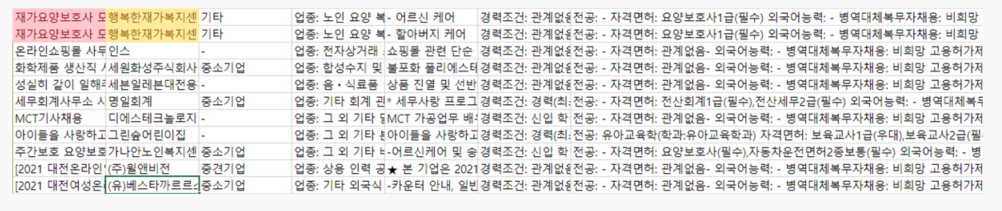

## insert 함수를 불러와서 DB에 데이터 저장

In [7]:
insert(job_csv_df)

CSV INSERT 시작
DB insert 완료


## 테이블 정보 조회
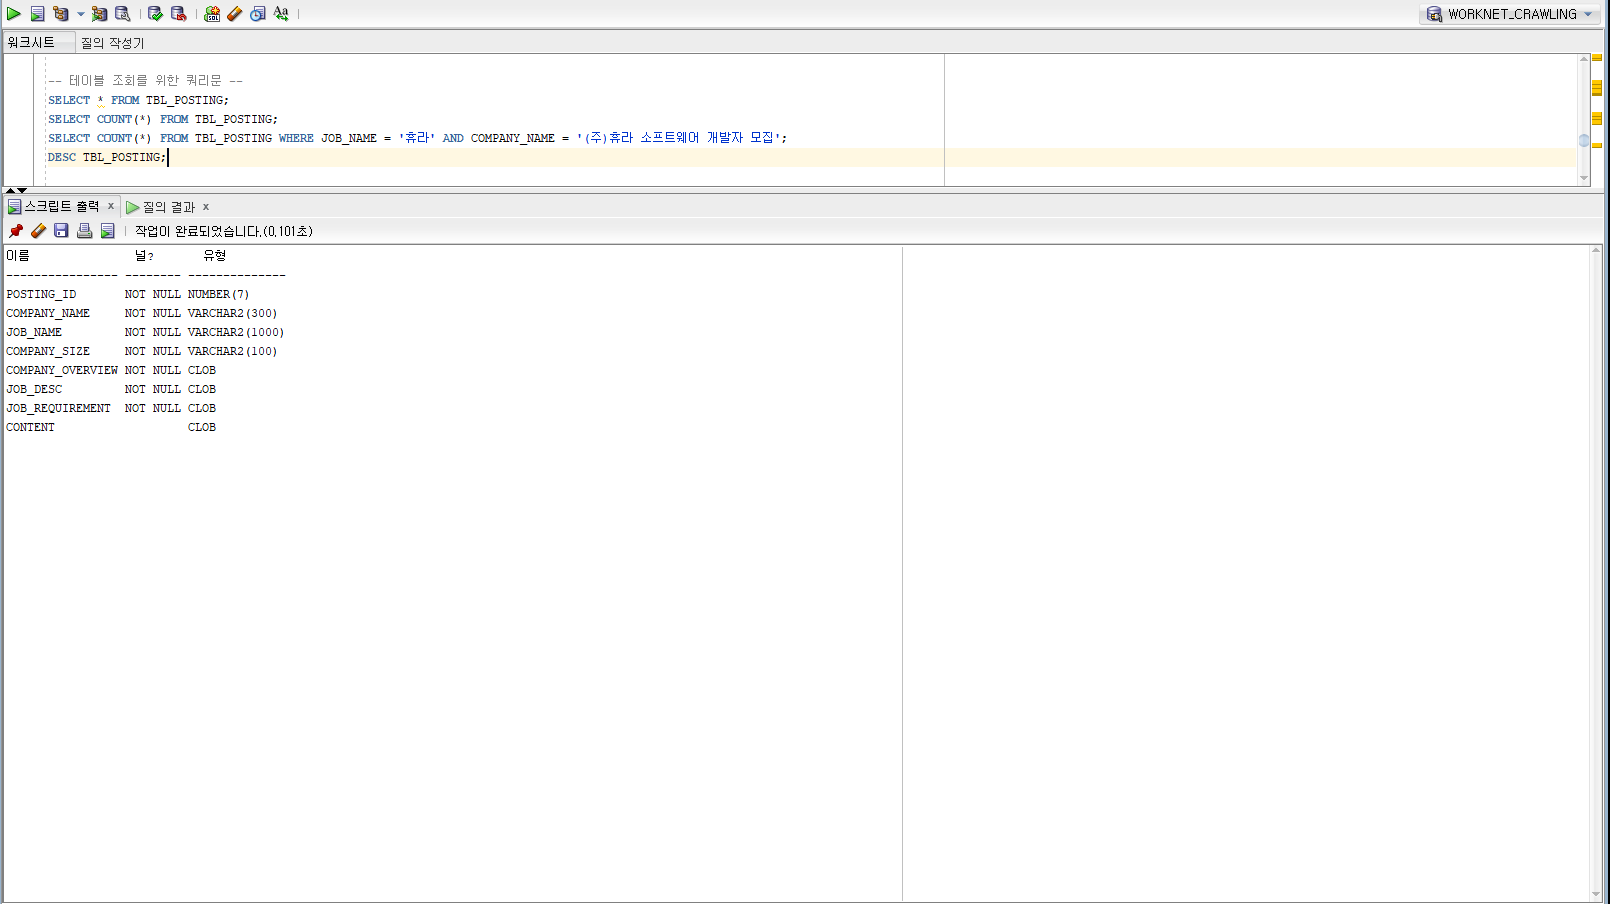
## 데이터 insert 유무 확인
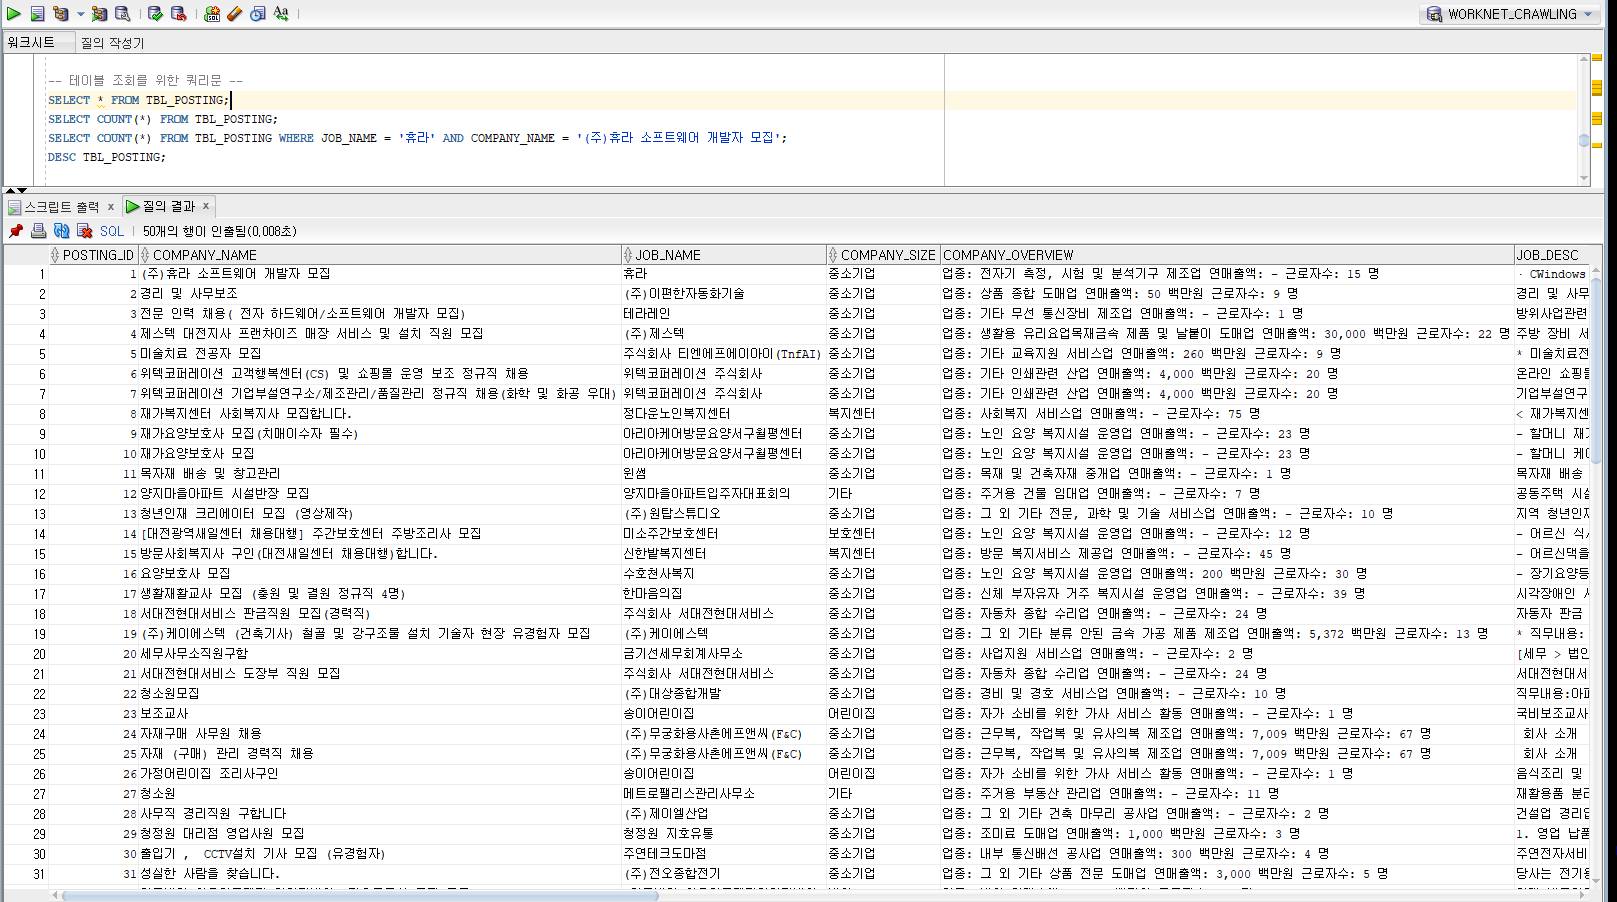
## insert 된 데이터 개수 확인 (1836개에서 중복데이터 제거 후 1825개)
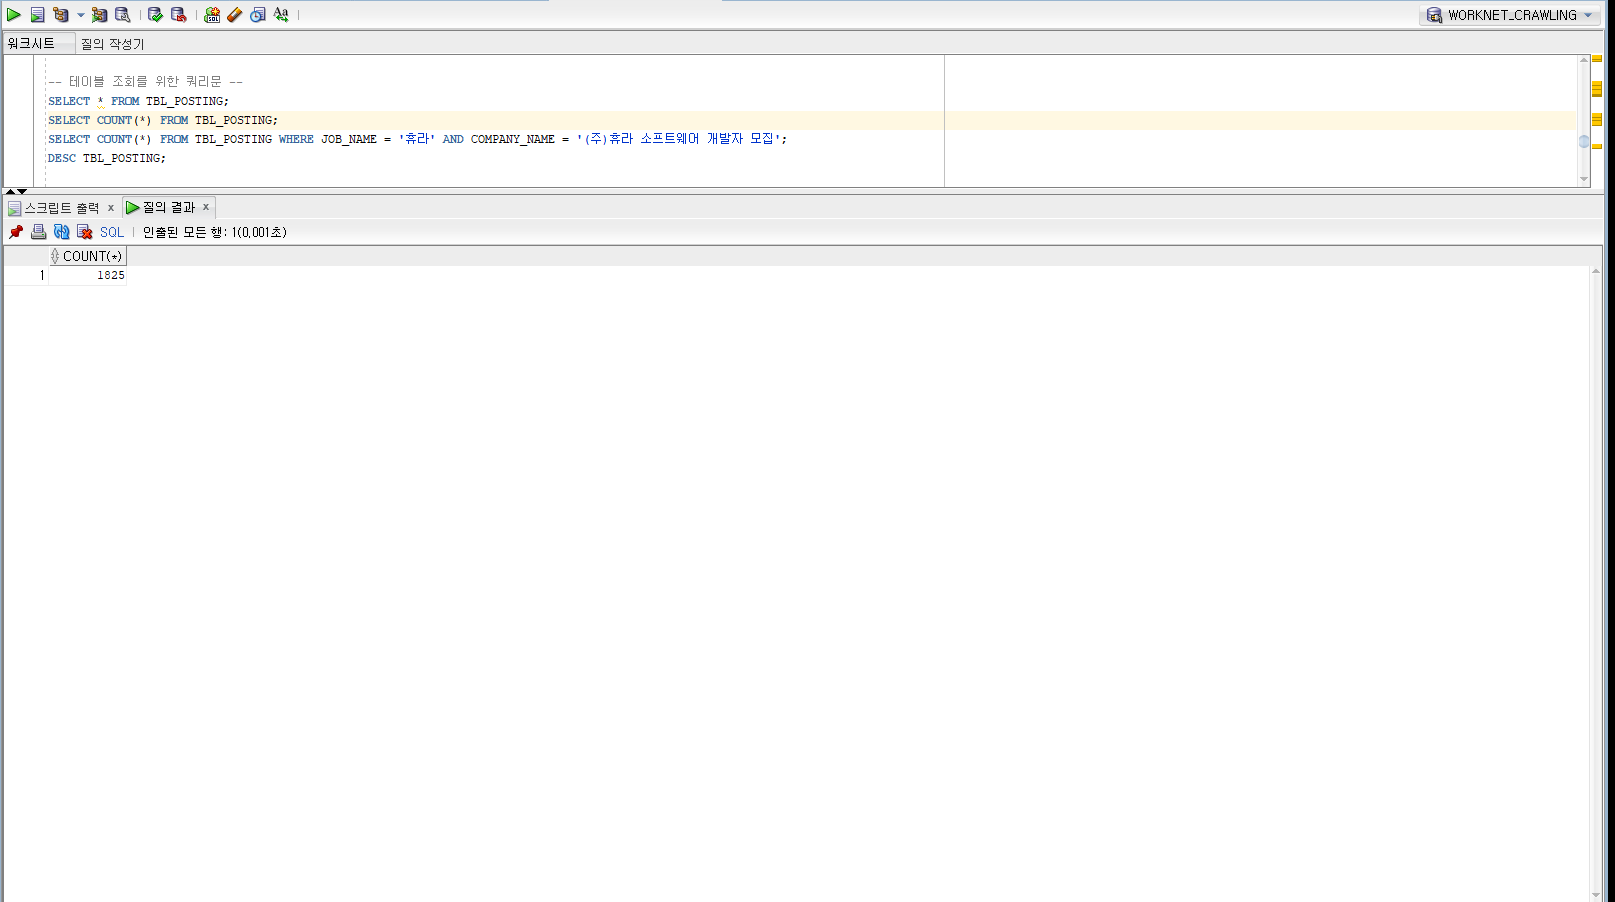
## 중복 데이터 유무 확인(채용직무와 기업명 기준)
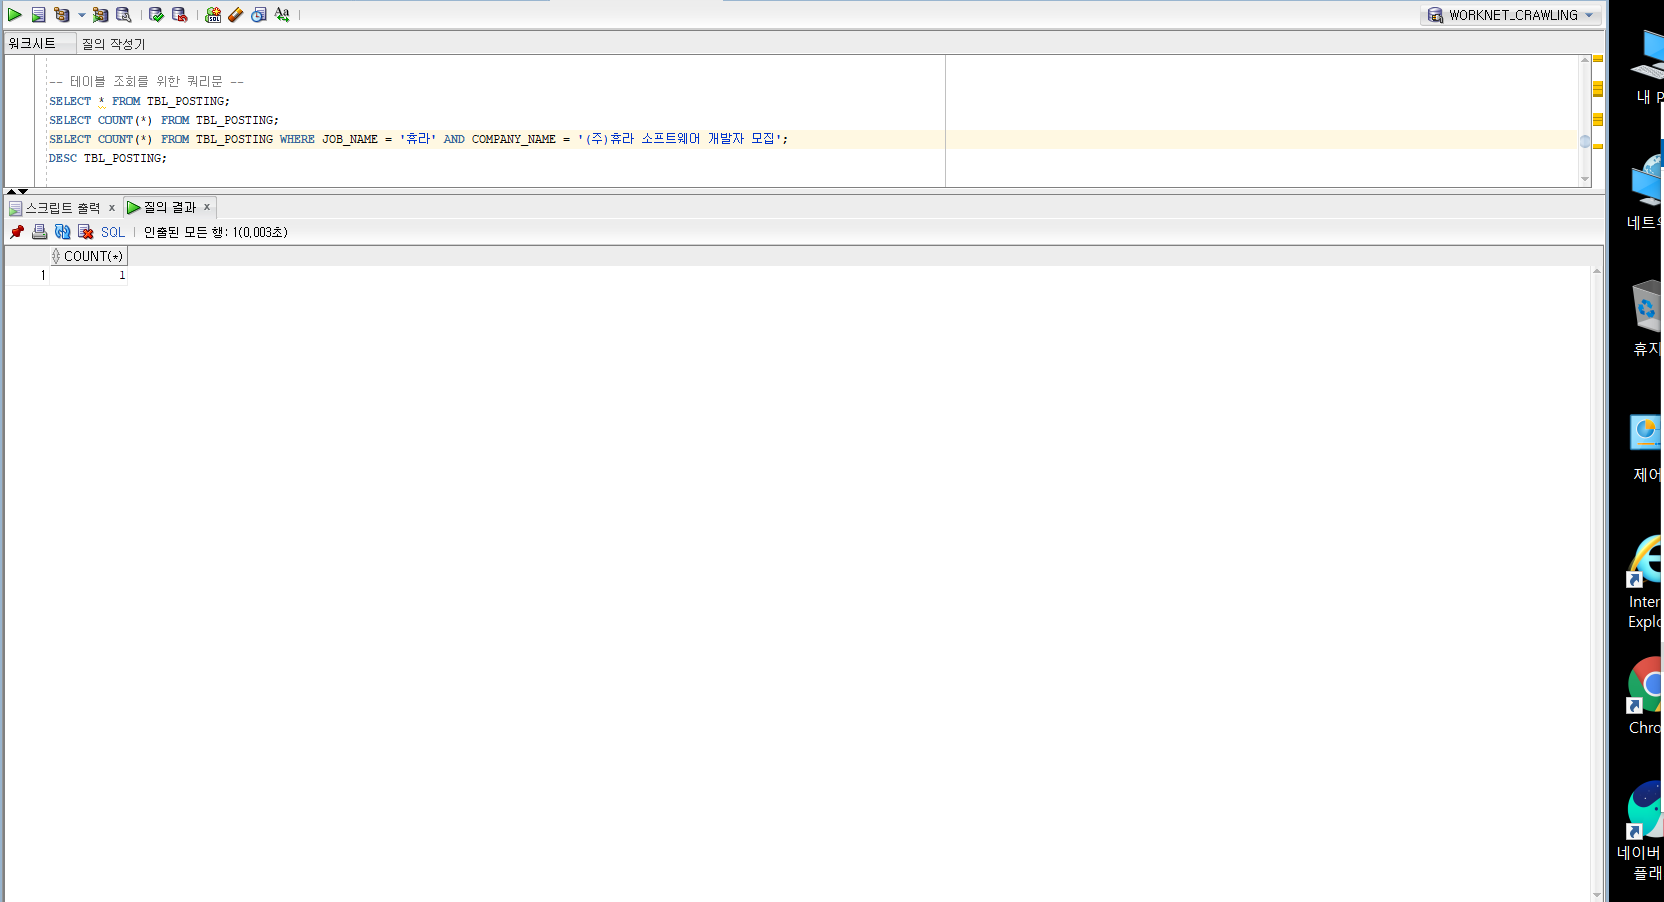